In [ ]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras.regularizers import l2

import shap
from tqdm import tqdm
# Surpressing Warnings
import warnings
import tensorflow as tf

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



# Loading Transformed Data

In [ ]:

file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
all_LagsHICP_Dir = "AllLagsHICP/"
all_LagsCPI_Dir = "AllLagsCPI/"
# all_LagsNonNormCPI_Dir = "AllLagsNNCPI/"
# all_LagsNonNormHICP_Dir = "AllLagsNNHICP/"

data = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_data_norm.csv')
data_acf_pacf = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_cf_lags_data_norm.csv')

# Consider Creating CSV for Data Description
df_date = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data_acf_pacf.set_index('DATE', inplace=True)
print(data.shape)
print(data.columns)


# Utility Functions

In [ ]:

sns.set_theme(style="whitegrid") # Apply seaborn visual theme

def plot_forecast(forecasted_series, actual_series, title_name='Forecasted vs Actual CPIAUCSL'):

    fig = plt.figure(figsize=(12, 6)) # Store figure object

    actual_series.index = pd.to_datetime(actual_series.index) # Try converting to DateTimeIndex

    plt.plot(actual_series.index, forecasted_series, label='Forecasted', color='#e41a1c', linestyle='dashed', linewidth=2) # Red for forecast
    plt.plot(actual_series.index, actual_series, label='Actual', color='#377eb8', linestyle='solid', linewidth=2) # Blue for actual

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.title(title_name, fontsize=12)

    # Date formatting for x-axis (using logic from your improved plot_series)
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels, adjust font size
    plt.gcf().autofmt_xdate() # Auto-format dates

    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout() # Adjust layout

    return fig # Return the figure object (do NOT use plt.show() here if you want to control display later)

def plot_observed_vs_fitted_var(var_model_fit, train_df, target_column='CPIAUCSL', title='VAR Model - Observed vs Fitted (Training)'):

    fitted_values = var_model_fit.fittedvalues # Get fitted values from the VAR model
    observed_train = train_df[target_column]   # Observed values from the training data

    # Extract fitted values for the target column
    fitted_cpiauscl = fitted_values[target_column]

    # Ensure index is DateTimeIndex if possible (align with actual_series index if needed)
    try:
        fitted_cpiauscl.index = pd.to_datetime(fitted_cpiauscl.index)
        observed_train.index = pd.to_datetime(observed_train.index) # Align observed index too for plotting
        if not fitted_cpiauscl.index.equals(observed_train.index): # If indexes still not the same, try to align based on actual index
            fitted_cpiauscl.index = observed_train.index # Force index alignment for plotting if possible
    except ValueError:
        print("Warning: Could not convert index to DateTime for Observed vs Fitted plot.")
        pass # Plot without DateTimeIndex if conversion fails

    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_cpiauscl.index, fitted_cpiauscl, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator() # Use observed_train index for locator
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predictions(y_actual, y_pred, train_index, title='CNN-LSTM: Actual vs Forecasted Values'):
    """Plots actual vs forecasted values."""
    train_index = pd.to_datetime(train_index)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_index, y_actual, label='Actual', color='blue', linestyle='solid')
    plt.plot(train_index, y_pred, label='Forecasted', color='red', linestyle='dashed')

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title, fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_loss(history):
    # Plots loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM - Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def plot_observed_vs_fitted(y_train, predictions_train, train_index):
    fig = plt.figure(figsize=(12, 6))
    train_index = pd.to_datetime(train_index)
    plt.plot(train_index, y_train, label="Observed (Train)", linestyle="solid")
    plt.plot(train_index, predictions_train, label="Fitted (Train)", linestyle="solid")
    plt.title("CNN-LSTM - Observed vs. Fitted Values")

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_arima_observed_vs_fitted(arima_model_fit, train_data, target_column, title='ARIMA Model - Observed vs Fitted (Training)'):
    """
    Plots observed vs fitted values for an ARIMA model on the training data,
    handling cases where fittedvalues might not have an index and ensuring index alignment.
    Includes enhanced index debugging.
    """

    observed_train = train_data[target_column] if isinstance(train_data, pd.DataFrame) else train_data # Handle DataFrame or Series input for train_data
    fitted_series = arima_model_fit.fittedvalues    # Ensure only train data is plotted (if fittedvalues has more values)

    num_values_to_keep = observed_train.index.shape[0]
    fitted_series_train = fitted_series[:num_values_to_keep]

    fitted_series_reduced = pd.Series(fitted_series_train, index=observed_train.index)

    # Extract fitted values for the target column
    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_series_reduced.index, fitted_series_train, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    return fig


# Creating Train and Test Data

In [ ]:
main_vars = ['GOODFBT', 'ECBIRRO', 'UNERWG', 'IPI', 'LTIR', 'RETAILGSR', 'RETAILXMV', 'ECBDFR', 'MMR', 'RETAILMV', 'AGRPROD', 'EPI', 'RETAILGF', 'PPIIP', 'UR', 'WPI', 'ECBMLFR', 'HICP', 'CPI_t+1']

s_df = pd.read_csv(filepath_or_buffer = all_LagsCPI_Dir + 'dfCPI_full_dataset_subsample_1.csv')
s_df.set_index('DATE', inplace=True)

In [ ]:
data_m = s_df[main_vars]
# print(data.columns)
# target = "dfCPI_L1"
target = "CPI_t+1"
target_hicp = "HICP_t+1"
# data = data.drop(columns="HICP")
# target = horizon_name

In [ ]:

# test_size = int(len(data_m) * 0.2)  # Convert percentage to absolute count
test_size = 12  # Convert percentage to absolute count
train_df = data_m.iloc[:-test_size]
test_df = data_m.iloc[-test_size:]

print(train_df.shape)
print(test_df.shape)


In [ ]:
print(train_df[target].tail())
print(test_df[target].head())


# VAR Model Training & Testing
Given that we need more observations than parameters. A rough formula:

Required observations > lag_order × num_variables²

We need to reduce the maxlags or number of variables.


In [ ]:

model = VAR(train_df)

# AIC based lag order (your original code)
lag_order_aic = model.select_order(maxlags=5).aic
print(f"AIC-based Lag Order: {lag_order_aic}")

# BIC based lag order
lag_order_bic = model.select_order(maxlags=5).bic
print(f"BIC-based Lag Order: {lag_order_bic}")

# HQIC based lag order
lag_order_hqic = model.select_order(maxlags=5).hqic
print(f"HQIC-based Lag Order: {lag_order_hqic}")

# Choose the lag order based on the criteria you prefer or by comparing performance with different lag orders.
var_lag_order = lag_order_aic # or lag_order_bic, or lag_order_hqic
var_model = model.fit(var_lag_order)
print(var_lag_order)

# var_model.summary()


In [71]:

def var_forecast(model, train_df, test_df, lag_order, forecast_horizon):

    input_data = train_df.values[-lag_order:]
    forecast = model.forecast(y=input_data, steps=forecast_horizon)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # -------------------------------
    # EVALUATE ON TARGET
    # -------------------------------
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))

    abs_err = np.abs(actual_cpi.values - forecasted_cpi.values)
    print(f"Abs Err: {abs_err}")

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return model, forecasted_cpi, actual_cpi, train_df, mae, rmse



# ***Results***


Abs Err: [0.0772994  0.69017761 1.25831783 1.27909724 1.37569054 0.00777097
 1.44369348 1.33047488 0.81314262 0.06264474 0.4703713  0.27470036]
Mean Absolute Error (MAE): 0.7569484128076681
Root Mean Squared Error (RMSE): 0.9314239850959224


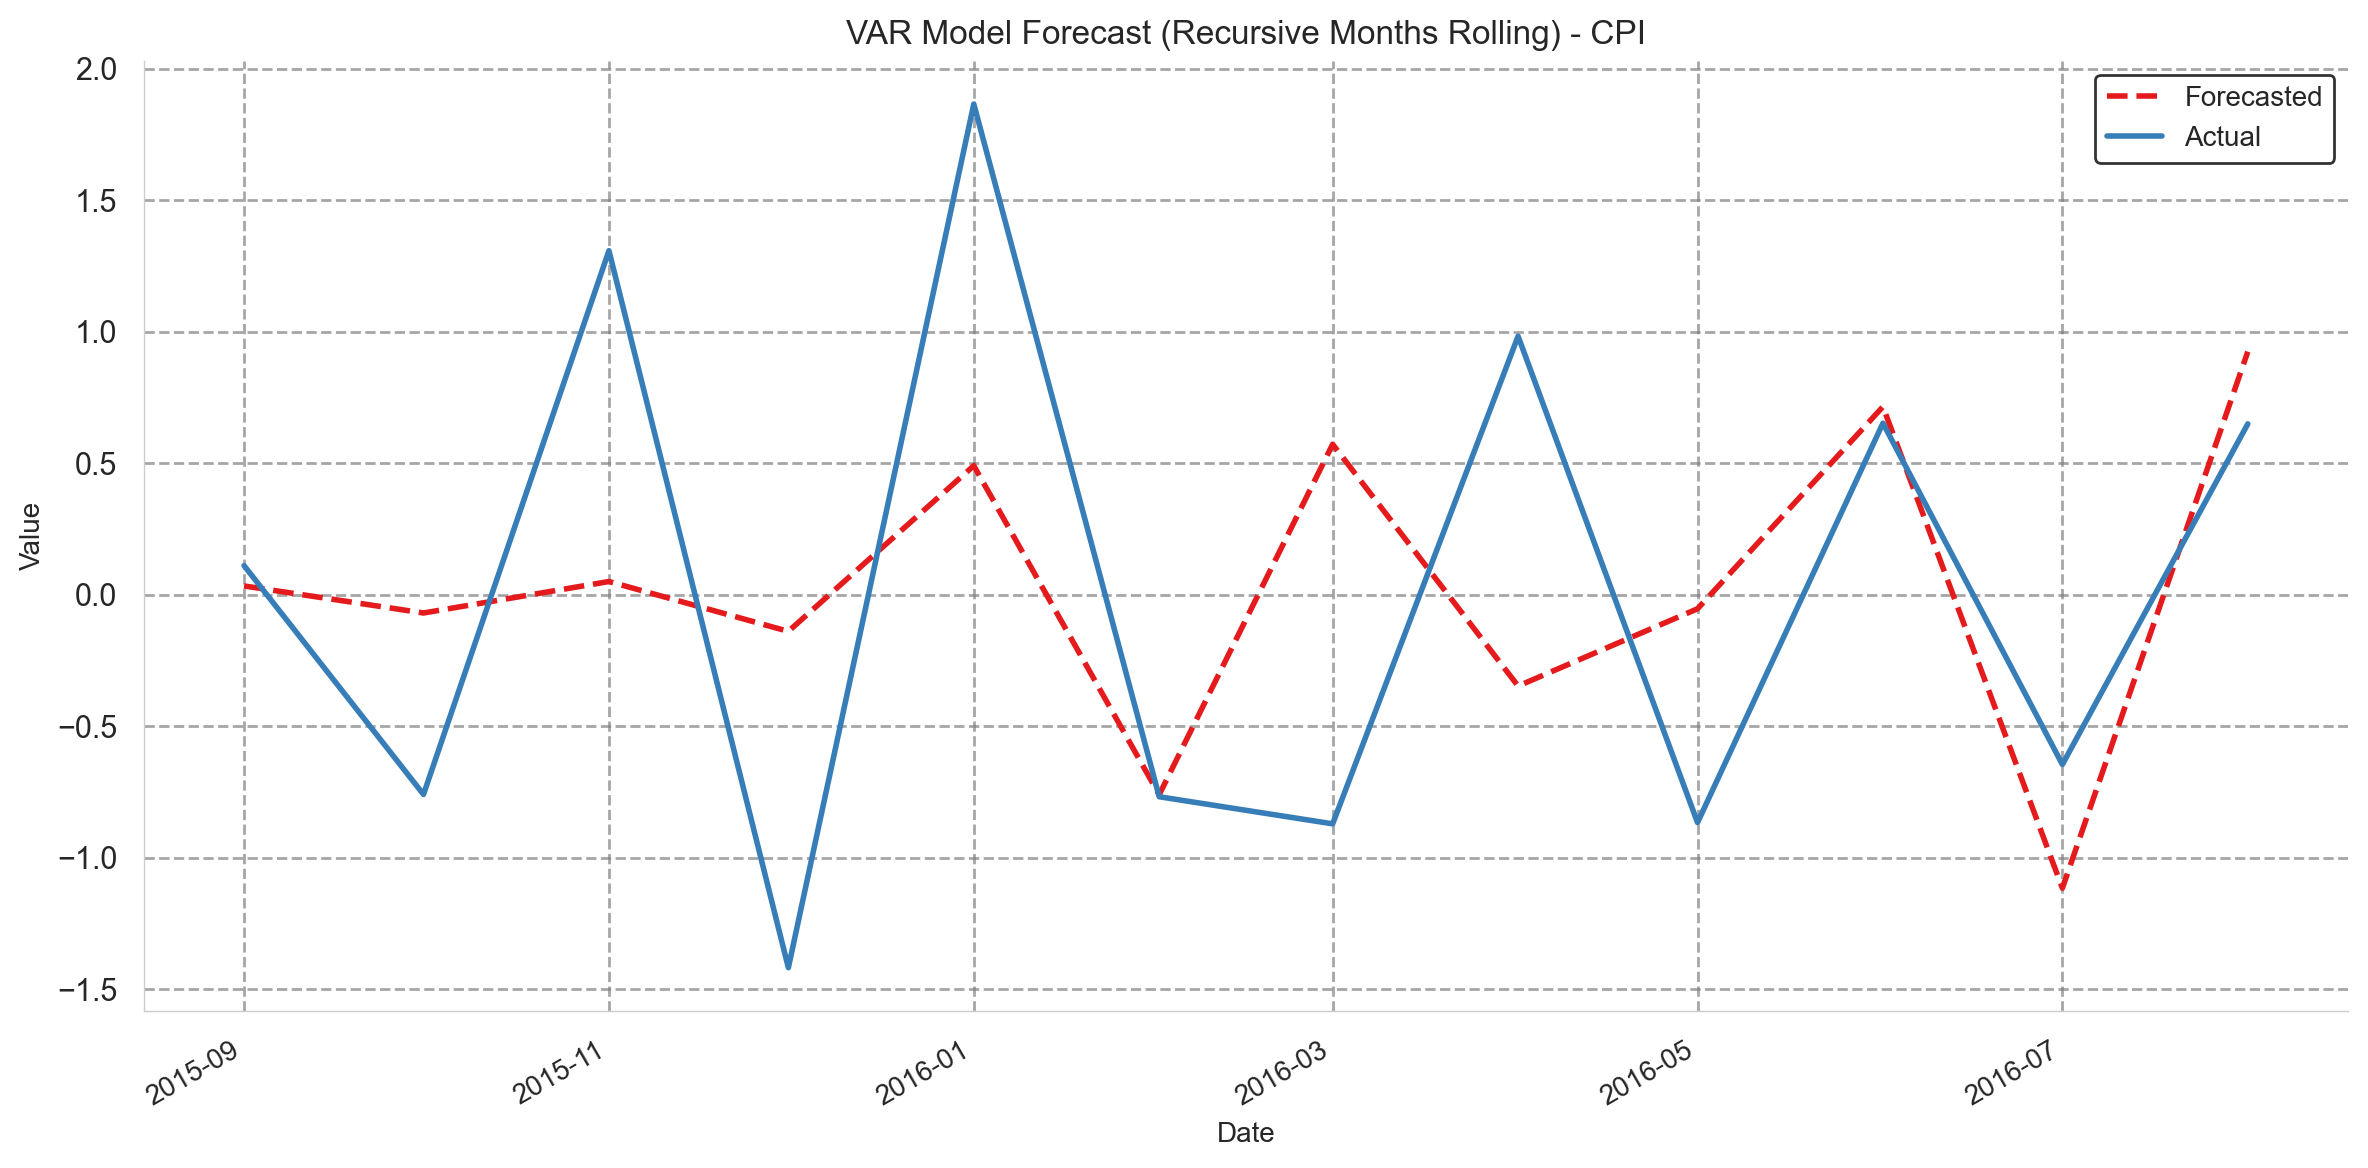

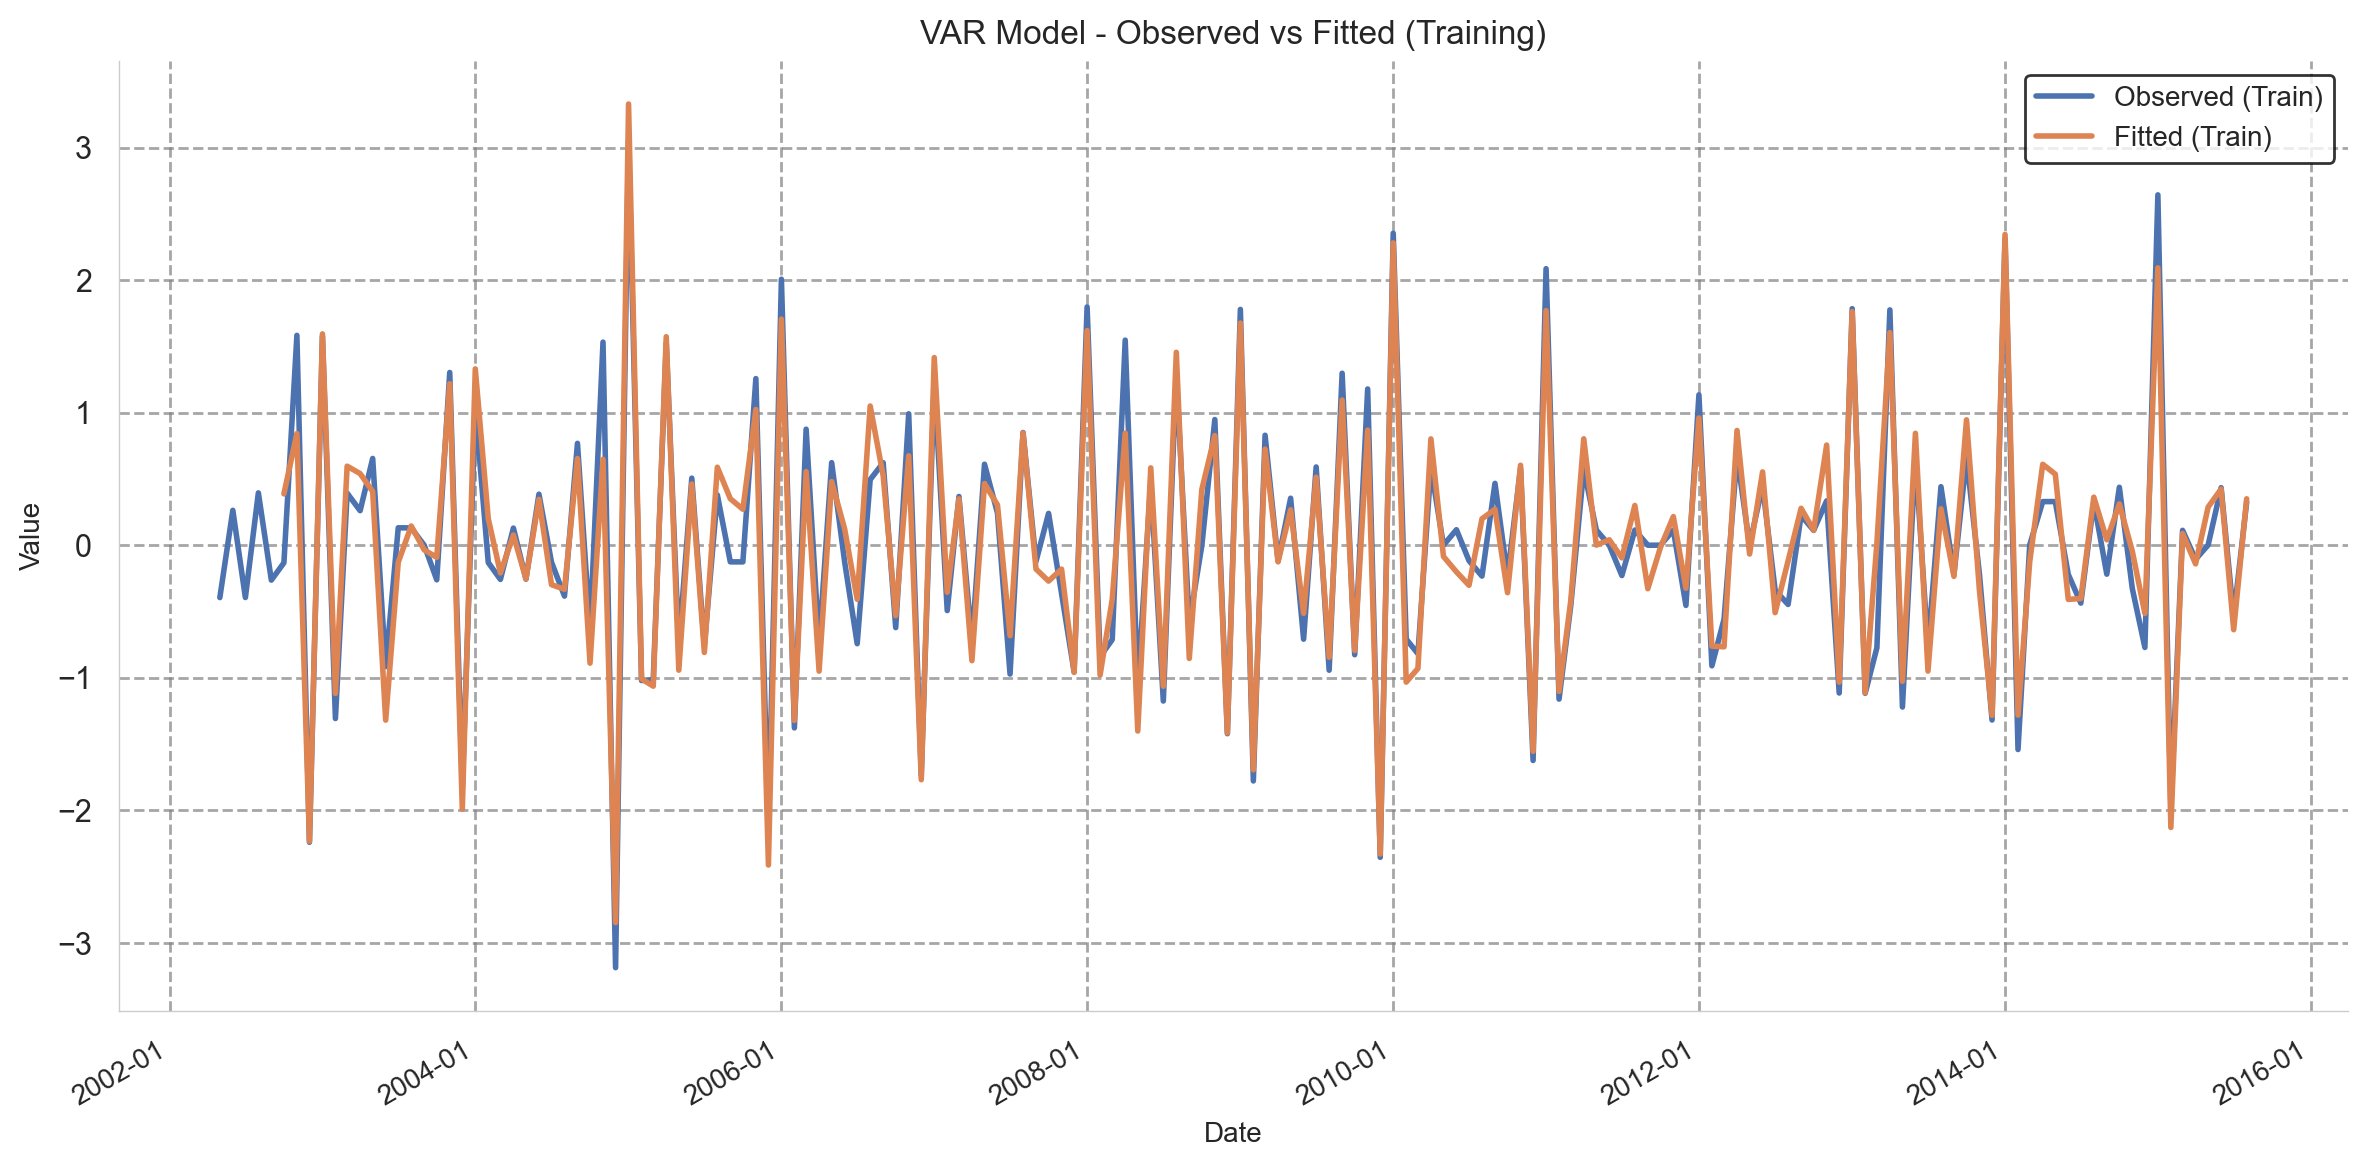

In [72]:
# # Forecast the next 12 months
model, forecasted_cpi, actual_cpi, var_train_df, var_mae, var_rmse = var_forecast(var_model, train_df.copy(), test_df.copy(), var_lag_order, test_size)
var_model_forecast_plot = plot_forecast(forecasted_cpi, actual_cpi, title_name='VAR Model Forecast (Recursive Months Rolling) - CPI')
var_observed_vs_fitted_plot = plot_observed_vs_fitted_var(model, var_train_df, target, 'VAR Model - Observed vs Fitted (Training)')


# ***ARIMA Training and Test***

In [ ]:

# Extract CPI series for ARIMA
train_cpi_arima = train_df.copy()[target]
test_cpi_arima = test_df.copy()[target]

In [68]:
# For ARIMA order selection (non-seasonal):
auto_arima_model_arima = auto_arima(train_cpi_arima, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action="ignore", max_order=10, trace=True)



/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=151.738, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=458.878, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=333.392, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=279.589, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=149.772, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=155.879, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=205.310, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=150.438, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=183.673, Time=0.02 sec


/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed 

 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=129.751, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec


/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=132.780, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec


/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=134.556, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.087 seconds


/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tf_cnn_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [69]:

def arima_mm_forecast(train_df, test_df, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted (24 Months Rolling)', target_column=target):
    """
    Performs a rolling multi-step-ahead ARIMA forecast for the entire test dataset.

    Parameters:
    - train_df (pd.DataFrame): Training data
    - test_df (pd.DataFrame): Test data
    - target_column (str): The target variable for evaluation (default 'CPIAUCSL')
    - steps (int): Number of steps ahead for each rolling forecast

    Returns:
    - forecast_df (pd.DataFrame): Forecasted values for the entire test period
    - mae (float): Mean Absolute Error
    - rmse (float): Root Mean Squared Error
    """

    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Build output DataFrame
    forecast_index = test_series.index[:forecast_horizon]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:forecast_horizon]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))

    print(f"ARIMA Model - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"ARIMA Model - Root Mean Squared Error (RMSE): {rmse:.4f}")

    # # Generate and display plots
    # print("Absolute Error")
    # abs_error = np.abs(actual_series.values - forecast_df[target].values)
    # print(abs_error)

    plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(model_fit, train_df, target_column=target_column, title=title) # Pass target_column

    plt.show()  # Display plots
    return forecast_df, mae, rmse


# Results

ARIMA Model - Mean Absolute Error (MAE): 0.8765
ARIMA Model - Root Mean Squared Error (RMSE): 0.9770
Absolute Error
[0.18091943 0.4166651  1.22300763 1.39932538 1.8600019  0.76858423
 0.87309381 0.98184765 0.86798327 0.65119451 0.64704187 0.64845678]


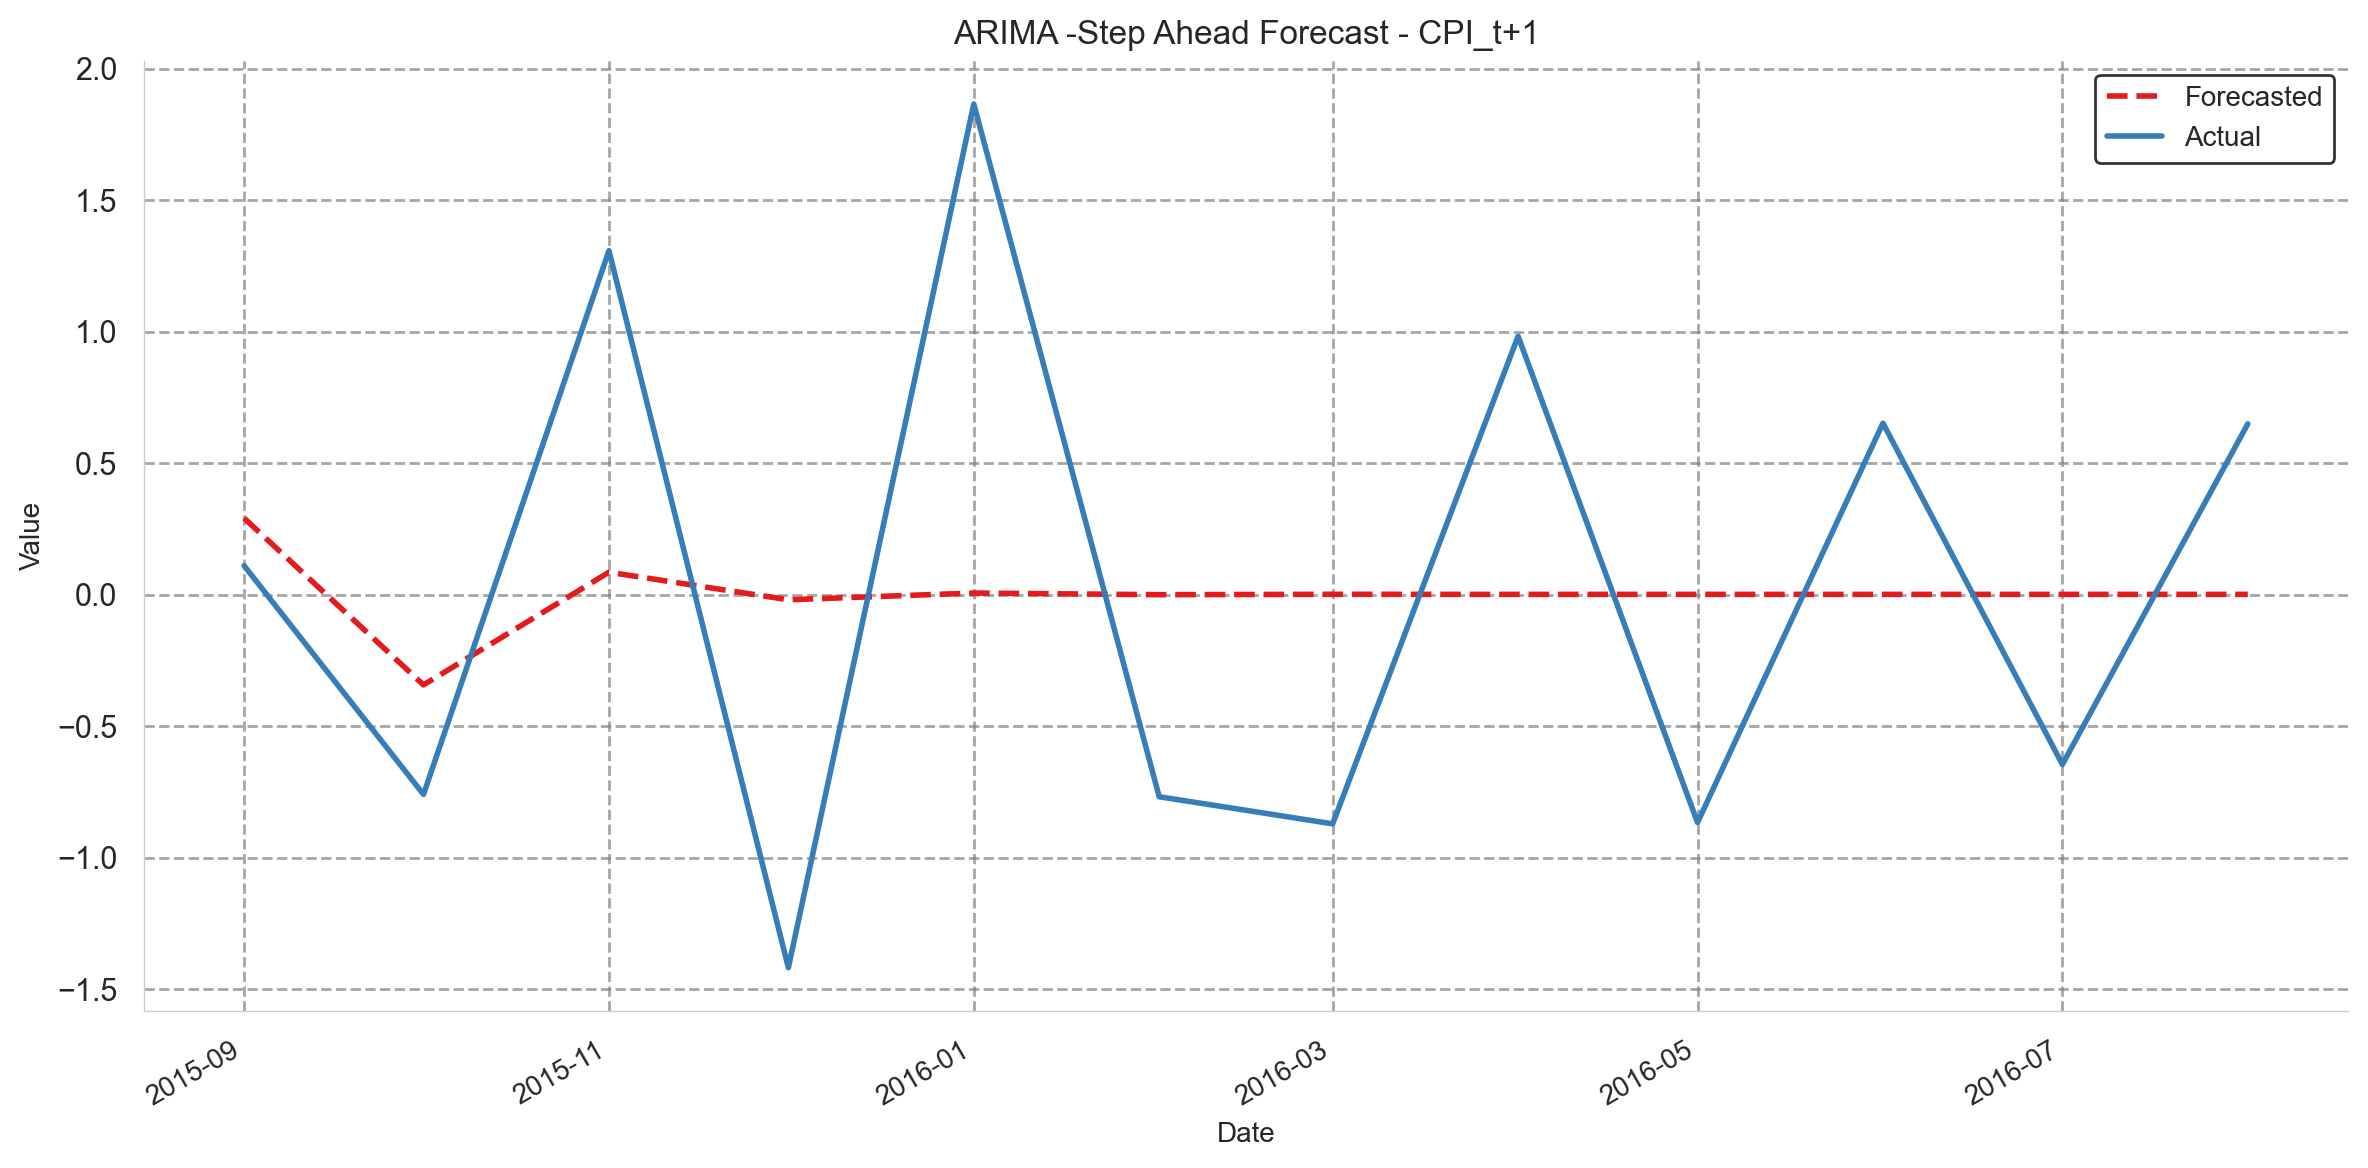

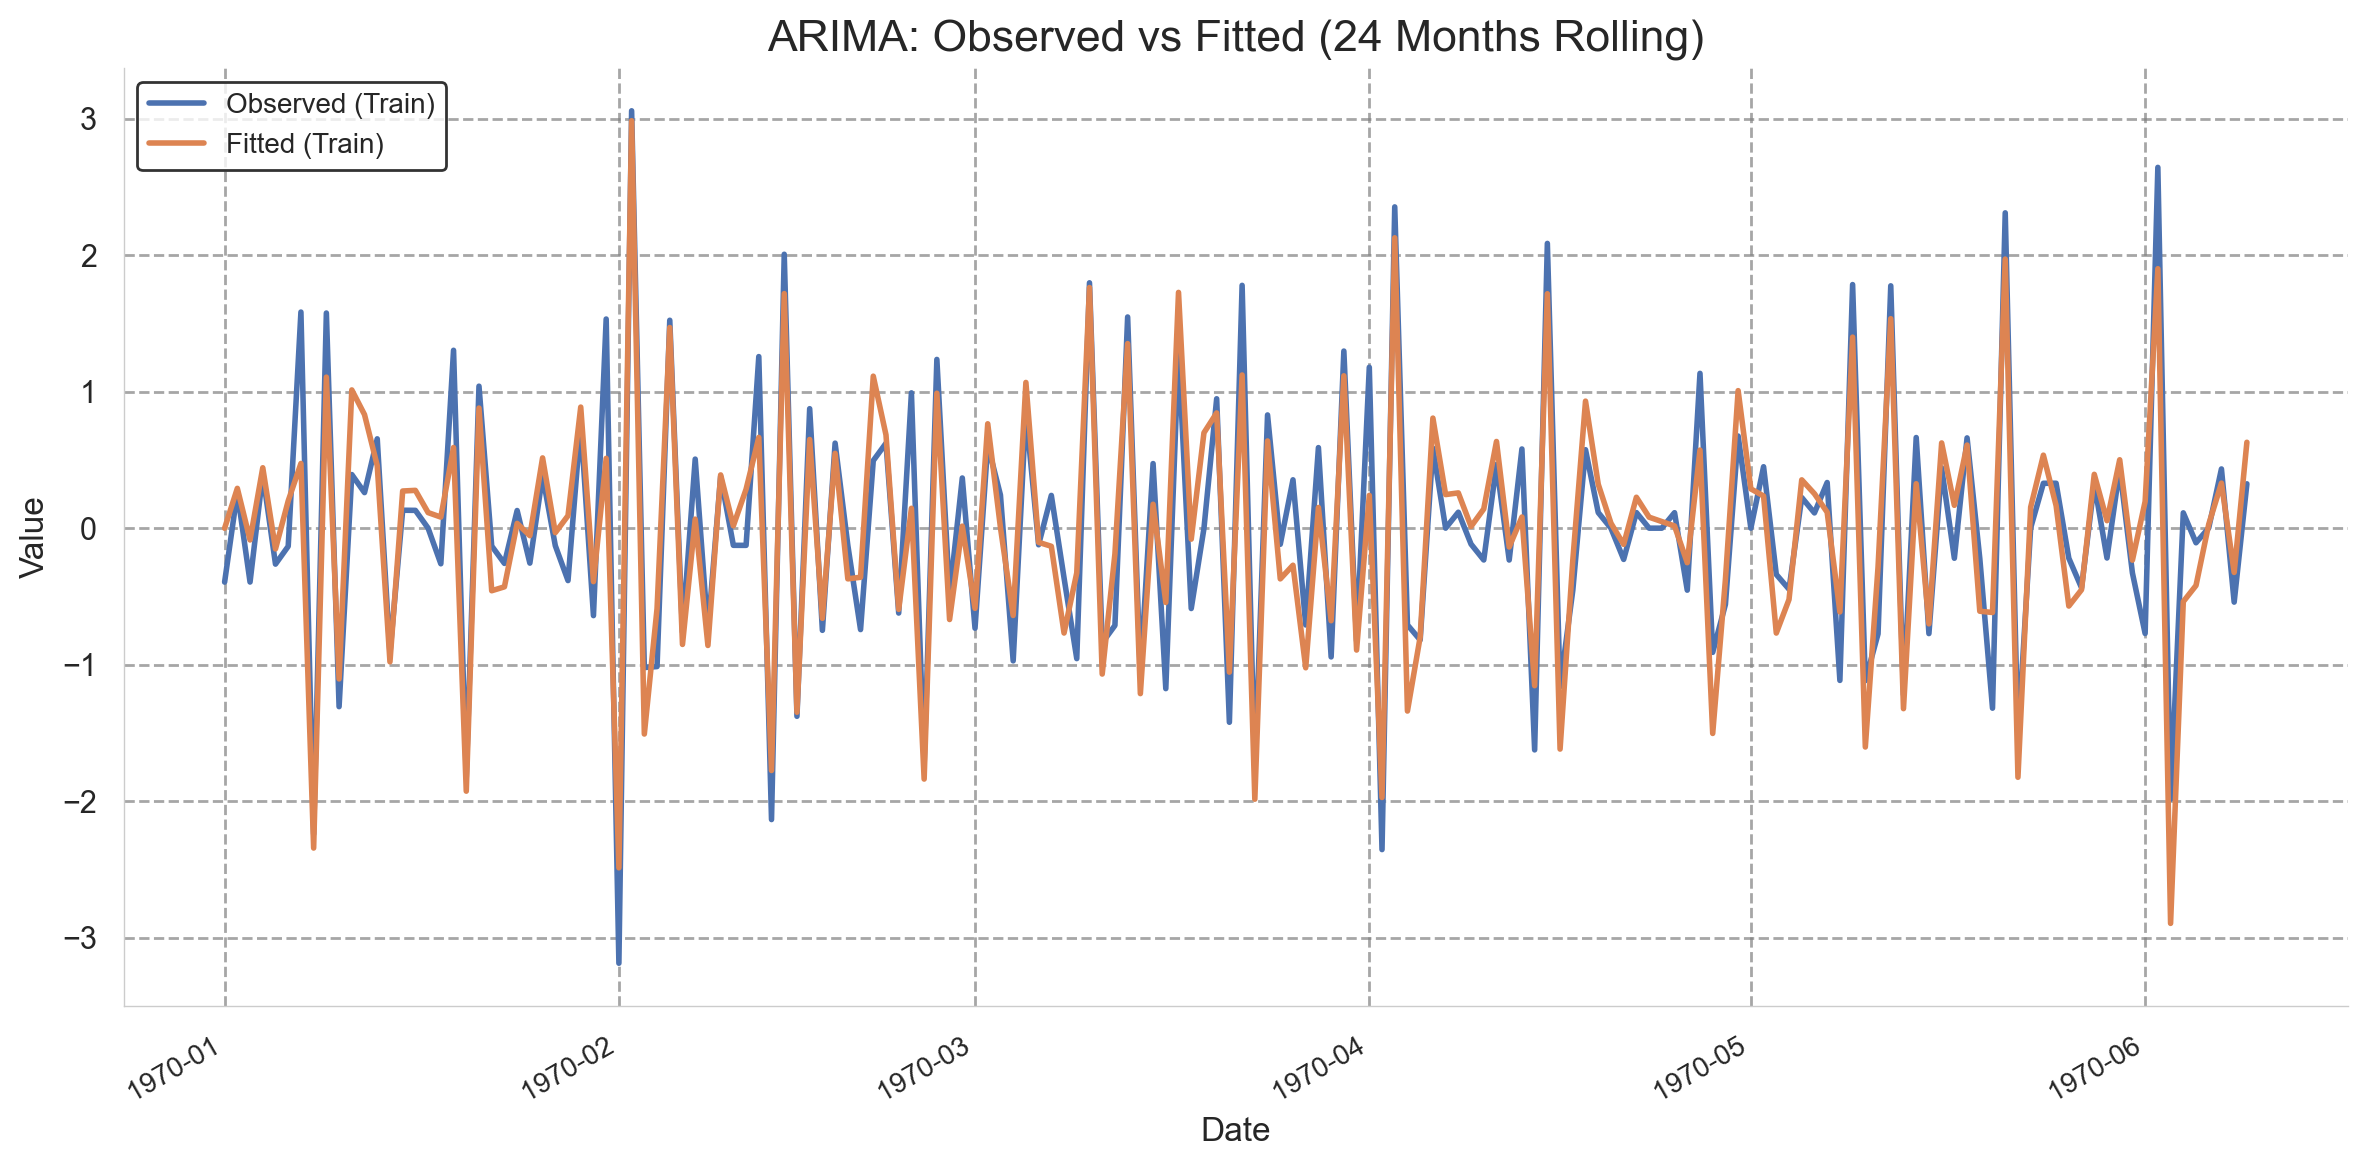

In [70]:
arima_forecast_df, arima_mae, arima_rmse = arima_mm_forecast(train_df, test_df, auto_arima_model_arima, test_size)


In [67]:
print(arima_forecast_df)

             CPI_t+1
DATE                
2015-09-01  0.291264
2015-10-01 -0.343272
2015-11-01  0.085210
2015-12-01 -0.019515
2016-01-01  0.006081
2016-02-01 -0.000175
2016-03-01  0.001354
2016-04-01  0.000980
2016-05-01  0.001071
2016-06-01  0.001049
2016-07-01  0.001054
2016-08-01  0.001053


# ***SARIMA Training & Test***


In [ ]:
train_cpi_sarima = train_df[target]


In [ ]:
# For SARIMA order selection (seasonal):
auto_arima_model_sarima = auto_arima(train_cpi_sarima, seasonal=True, m=12, stepwise=True, # m=12 for monthly seasonality
                                     suppress_warnings=True, error_action="ignore", max_order=10, trace=True,
                                     max_p=10, max_q=10, max_P=10, max_Q=10, verbose=0) # Limit search space


In [ ]:

def sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size, target_column=target):

    # Extract CPI series for ARIMA
    train_cpiauscl_arima = train_df[target_column]
    test_cpiauscl_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_cpiauscl_arima.index = pd.to_datetime(train_cpiauscl_arima.index)

    history = train_cpiauscl_arima.tolist()
    sarima_model = SARIMAX(history,
                          order=auto_arima_model_sarima.order,
                          seasonal_order=auto_arima_model_sarima.seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)

    forecast_df = pd.DataFrame(forecast, index=test_cpiauscl_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpiauscl_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpiauscl_arima, forecast_df[target_column]))

    # Print evaluation metrics
    print(f'Rolling SARIMA Model - Mean Absolute Error (MAE): {mae_sarima:.4f}')
    print(f'Rolling SARIMA Model - Root Mean Squared Error (RMSE): {rmse_sarima:.4f}')

    # Plot the forecast and the fitted model
    print("DETAILS")
    print(forecast_df.shape)
    print(test_cpiauscl_arima.shape)
    print(sarima_model_fit.fittedvalues.shape)
    sarima_forecast = plot_forecast(forecast_df, test_cpiauscl_arima, title_name='Rolling SARIMA Model Forecast - CPI')
    sarima_fitted = plot_arima_observed_vs_fitted(sarima_model_fit, train_df, target_column=target_column, title='SARIMA Model - Observed vs Fitted (24 Months Rolling)')
    plt.show()

    return sarima_forecast, mae_sarima, rmse_sarima



# Result

In [ ]:

sarima_forecast, sarima_mae, sarima_rmse = sarima_mm_forecast(train_df, test_df, auto_arima_model_sarima, test_size)


# ***CNN-LSTM Training & Testing***

In [18]:

def prepare_data(data, target_column, test_size):
    data_x = data.copy()
    train_df = data_x.iloc[:-test_size]
    test_df = data_x.iloc[-test_size:]
    train_index = train_df.index
    test_index = test_df.index

    feature_names_used = data_x.drop(target_column, axis=1).columns.tolist()
    X_train = train_df.drop(target_column, axis=1).values
    y_train = train_df[target_column].values.reshape(-1, 1)
    X_test = test_df.drop(target_column, axis=1).values
    y_test = test_df[target_column].values.reshape(-1, 1)

    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scalers on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Transform test data
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    # Reshape for ConvLSTM2D: [samples, timesteps, rows, cols, channels]
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, 1, 1, X_train_scaled.shape[1]))
    X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, 1, 1, X_test_scaled.shape[1]))

    return X_train, y_train_scaled, X_test, y_test_scaled, train_index, test_index, scaler_y, feature_names_used


In [33]:


# BEST SO FAR 128, 16
def build_model(input_shape):
    """Builds and compiles a ConvLSTM2D model."""
    model = Sequential([
        ConvLSTM2D(filters=16, kernel_size=(1, 1), activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.002)),
        ConvLSTM2D(filters=8, kernel_size=(1, 1), activation='tanh', return_sequences=False, kernel_regularizer=l2(0.002)),
        # Dropout(0.6),
        Flatten(),
        Dense(1)
    ])
    opt = Adam(learning_rate=0.0007)
    model.compile(optimizer=opt, loss='mse')
    return model

def train_model(model, X_train, y_train, batch_size=16):
    """Trains the model with early stopping."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=600, callbacks=[early_stopping], verbose=0)
    return history

def evaluate_model(model, X_test, y_test, batch_size=16):
    """Evaluates the model and returns the test loss and predictions."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    loss = model.evaluate(train_dataset, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    return loss, predictions

def inverse_transform(scaler, data):
    """Inverse transforms the scaled data."""
    return scaler.inverse_transform(data.reshape(-1, 1))

def cnn_lstm_model(data, test_size=test_size):
    """Main function to execute the pipeline."""
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used = prepare_data(data, target, test_size=test_size)
    model = build_model((1, 1, 1, X_train.shape[-1]))
    history = train_model(model, X_train, y_train)

    loss, predictions = evaluate_model(model, X_test, y_test)
    # print(f'Test Loss: {loss}')
    
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)

    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    plot_cnn_forecast = plot_predictions(y_test_actual, predictions_actual, test_index)
    # plot_loss(history)

    predictions_train = model.predict(X_train, verbose=0) # Predict on X_train
    predictions_train_actual = inverse_transform(scaler_y, predictions_train) # Inverse transform fitted values
    y_train_actual = inverse_transform(scaler_y, y_train) # Inverse transform y_train

    # --- Plot Observed vs Fitted on Training Data ---
    plot_cnn_obs_vs_fitted = plot_observed_vs_fitted(y_train_actual, predictions_train_actual, train_index) # Pass y_train_actual and predictions_train_actual
    # plot_observed_vs_fitted(y_train, predictions)

    print(f'Mean Absolute Error (MAE): {mae:.8f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.8f}')
    return model, X_train, X_test, mae, rmse, feature_names_used



In [23]:
print(data.shape)

(304, 115)


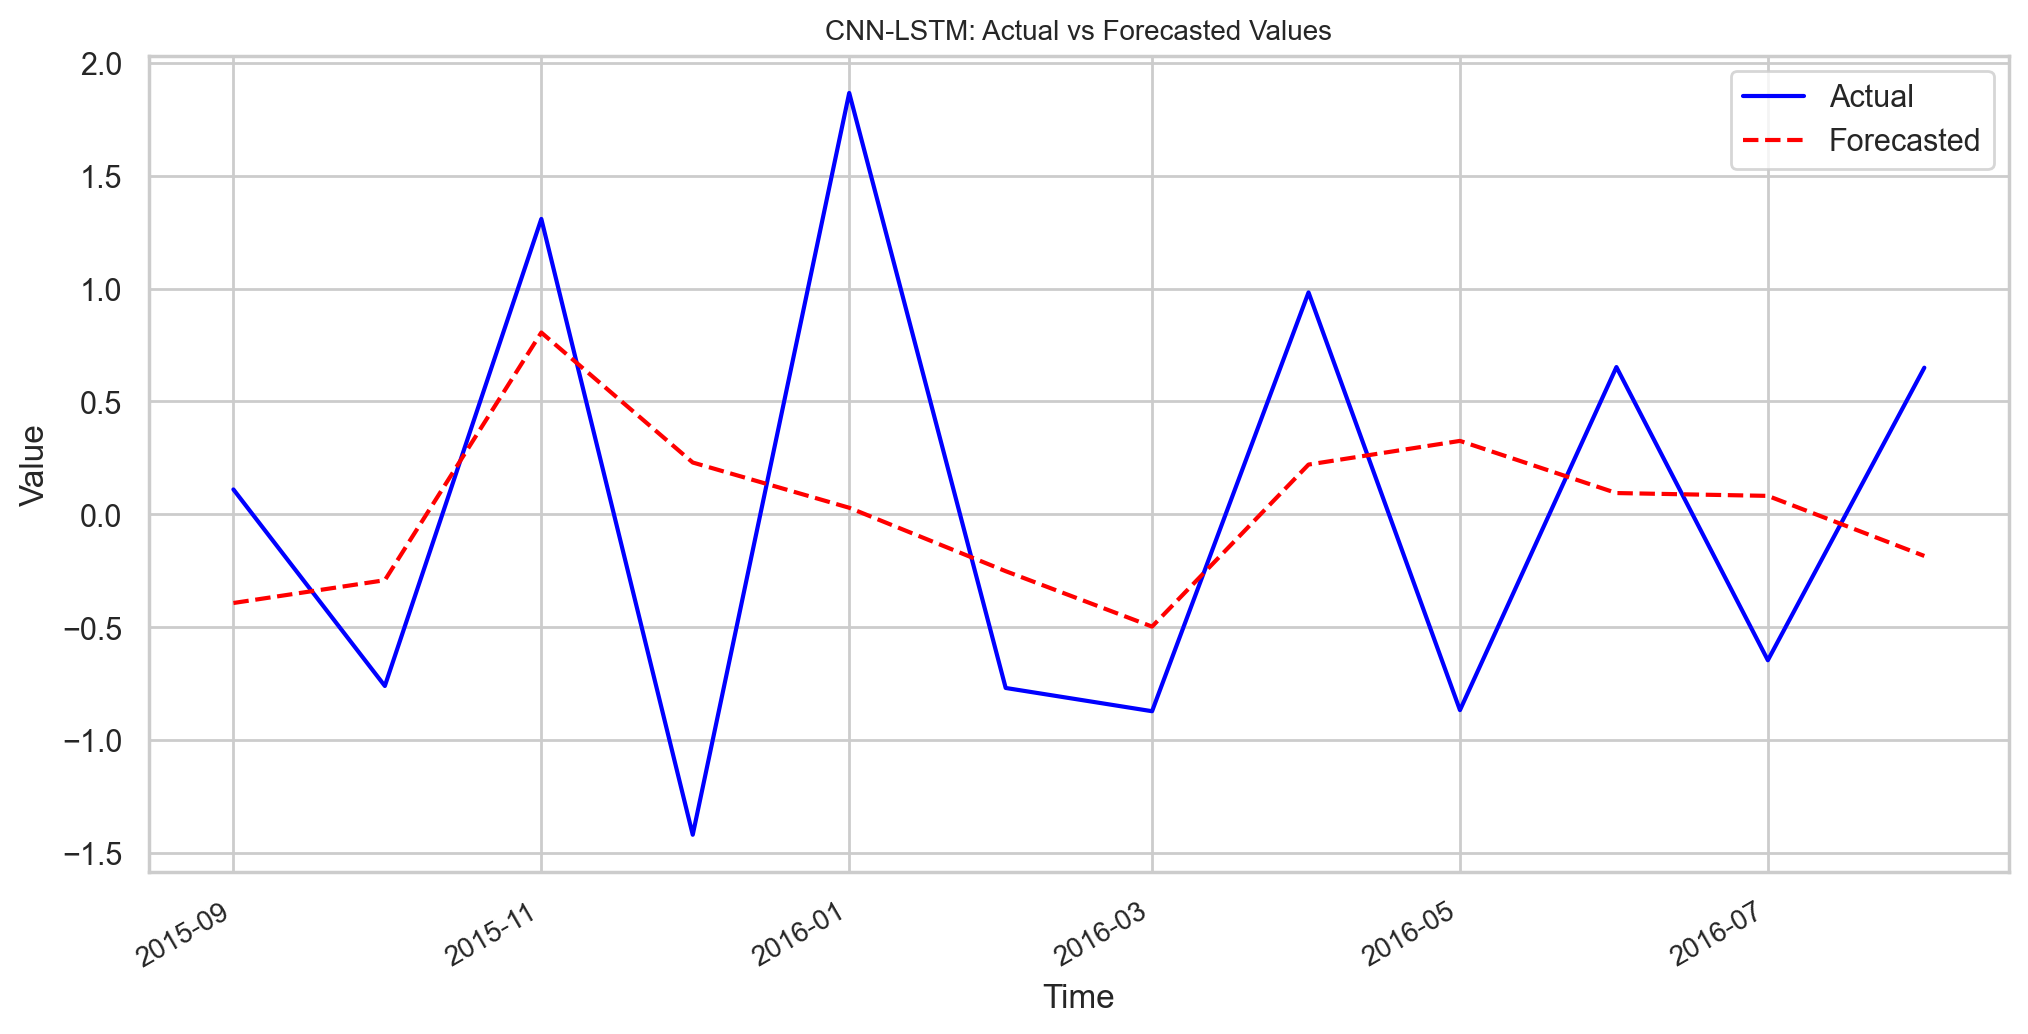

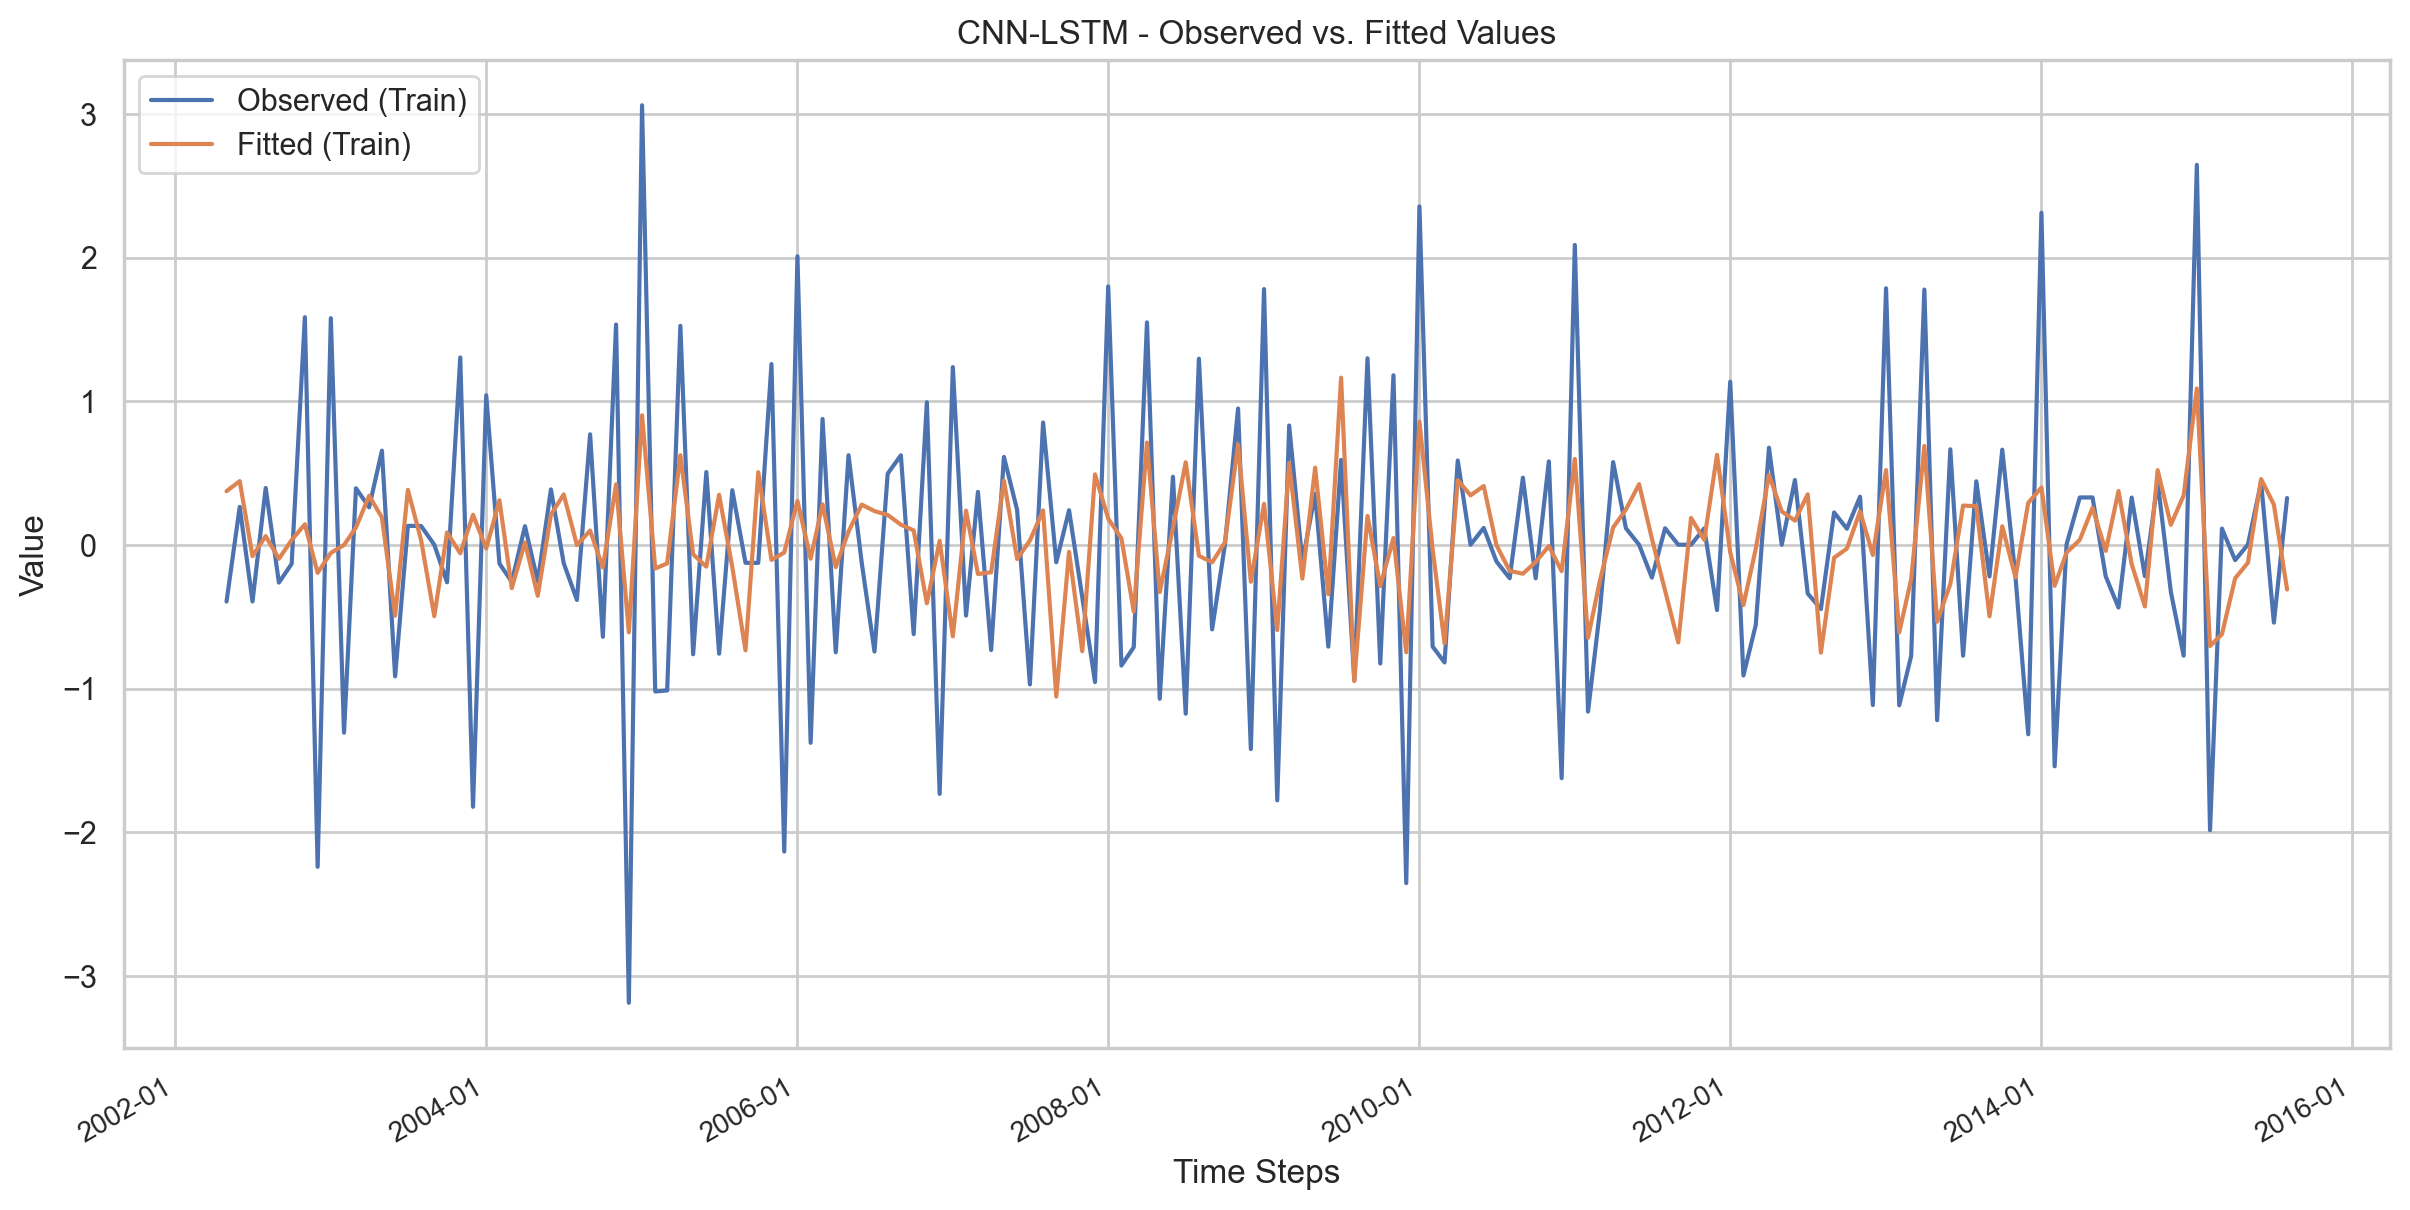

Mean Absolute Error (MAE): 0.82711719
Root Mean Squared Error (RMSE): 0.94706078


In [30]:
model, X_train, X_test, no_lags_cnn_mae, no_lags_cnn_rmse, fnames_no_lags = cnn_lstm_model(data_m, test_size)

ACF/PACF Lags

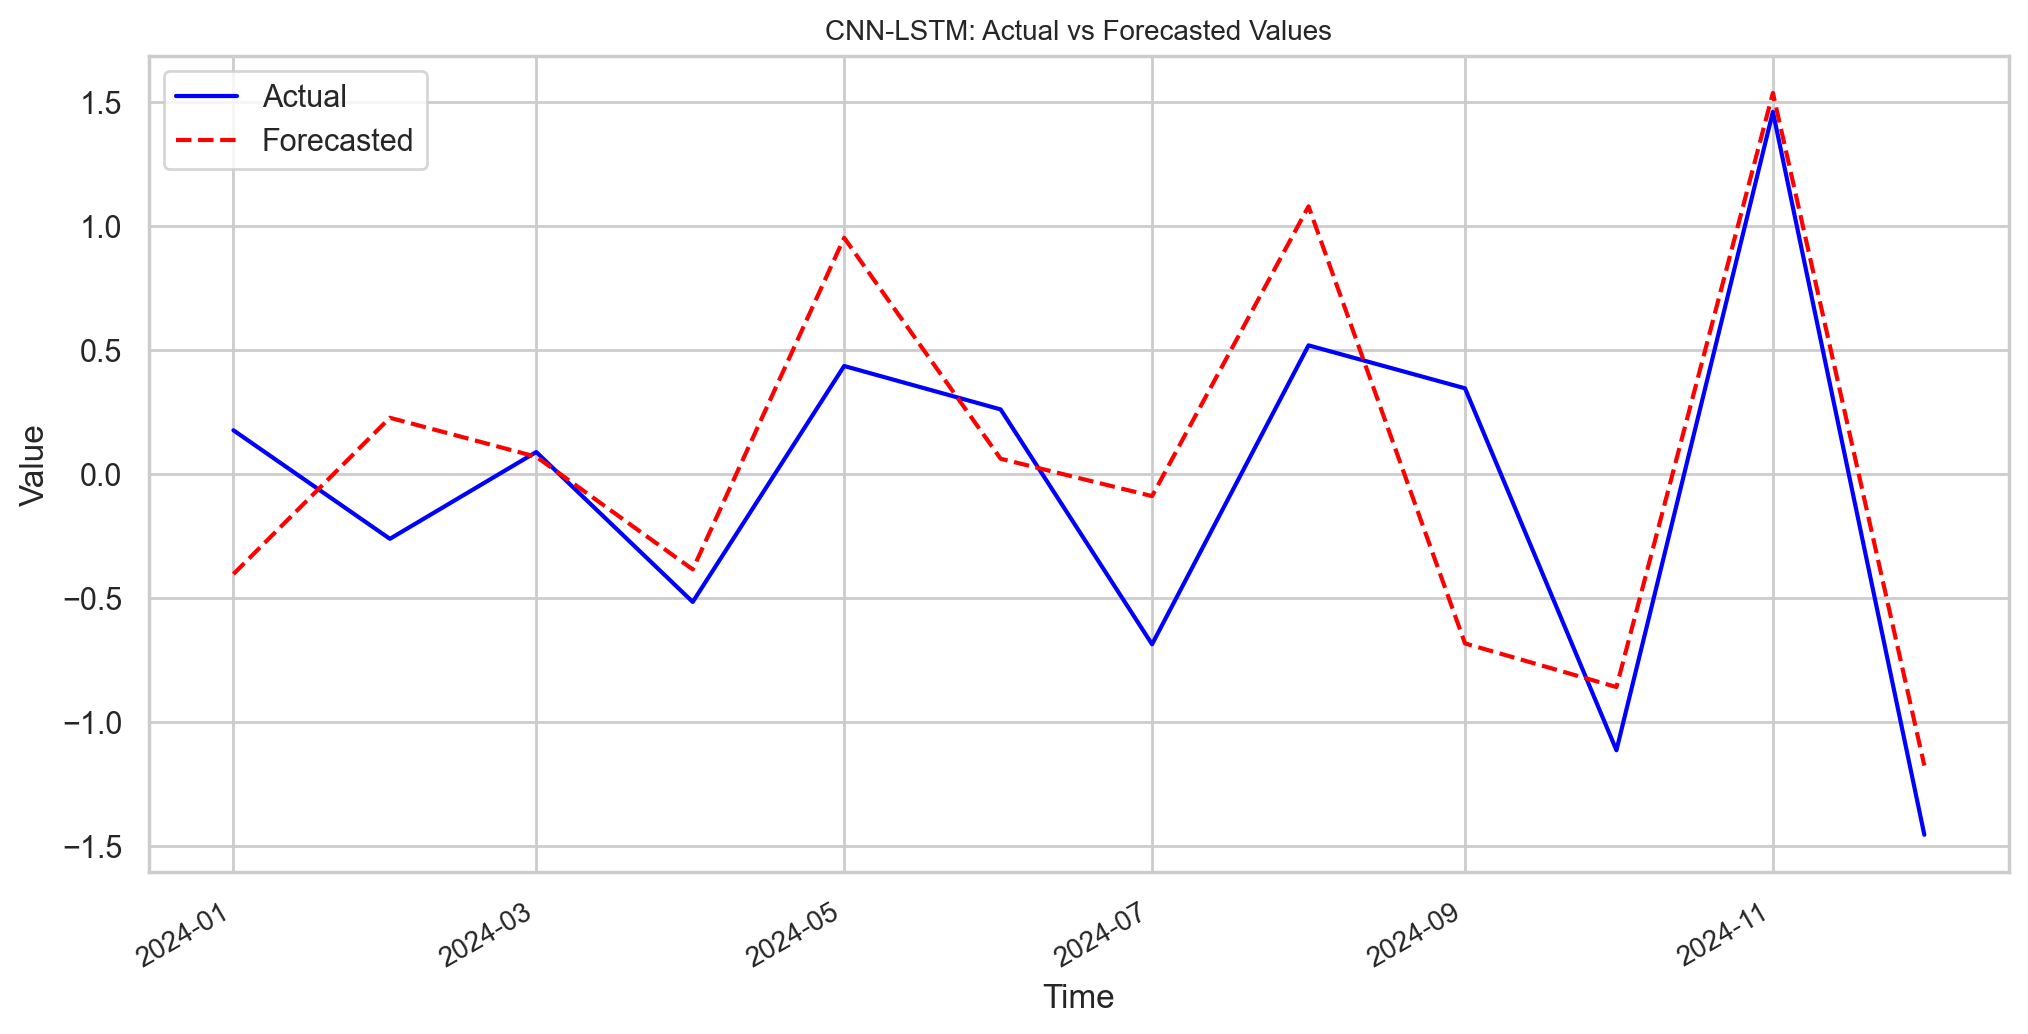

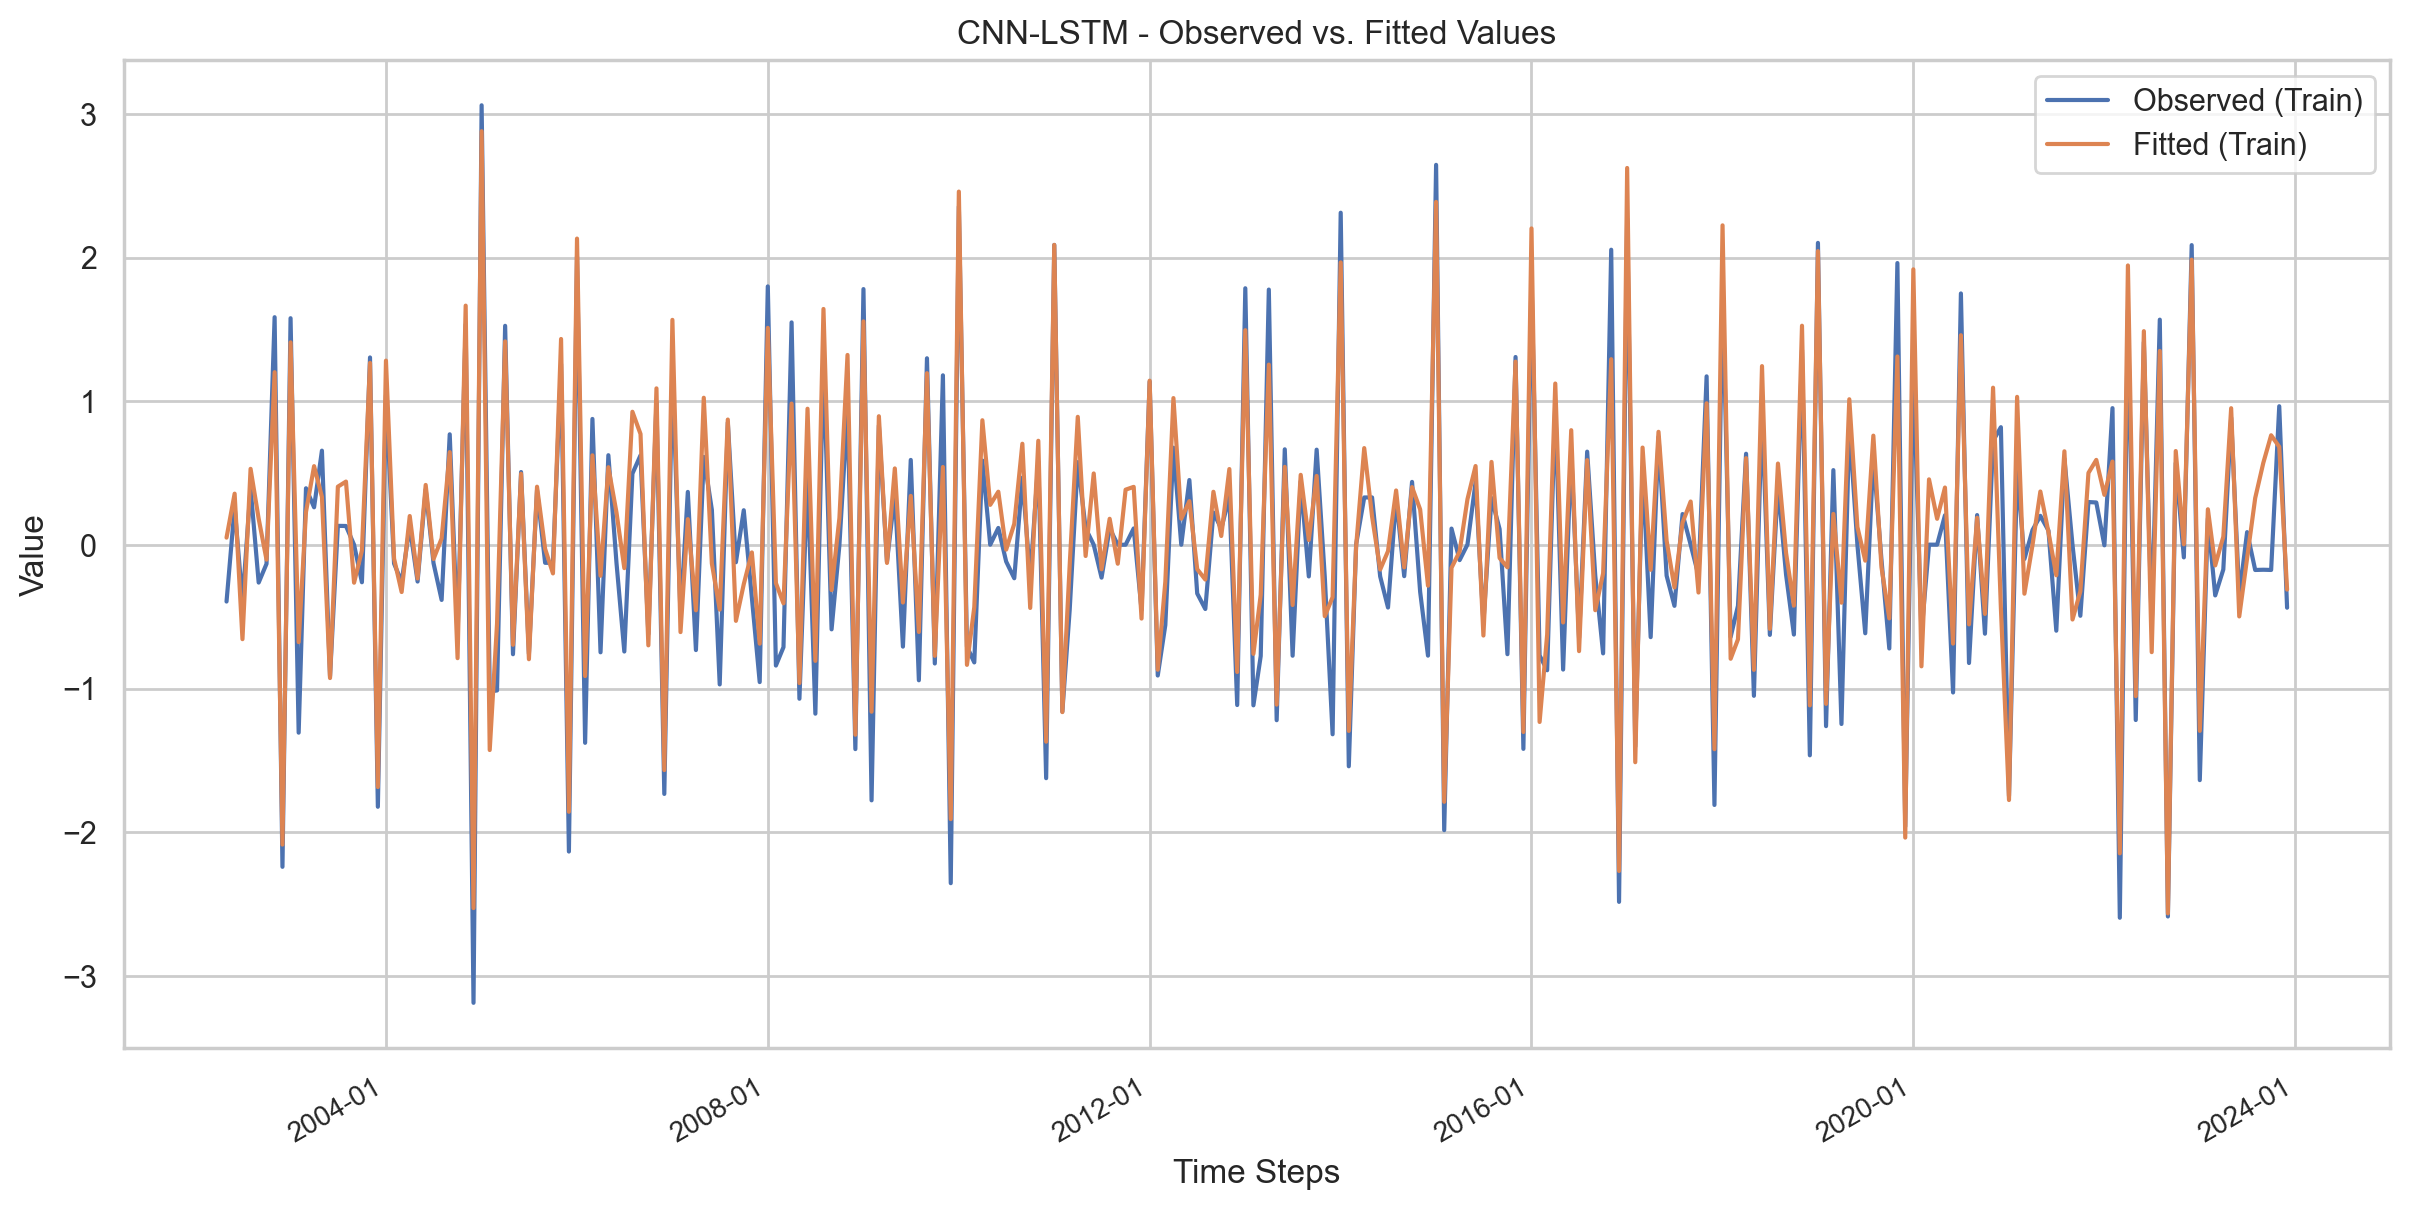

Mean Absolute Error (MAE): 0.39416574
Root Mean Squared Error (RMSE): 0.48098277


In [34]:
model, X_train, X_test, pacf_cnn_mae, pacf_ccnn_rmse, feature_names_acf_pacf = cnn_lstm_model(data_acf_pacf, test_size)

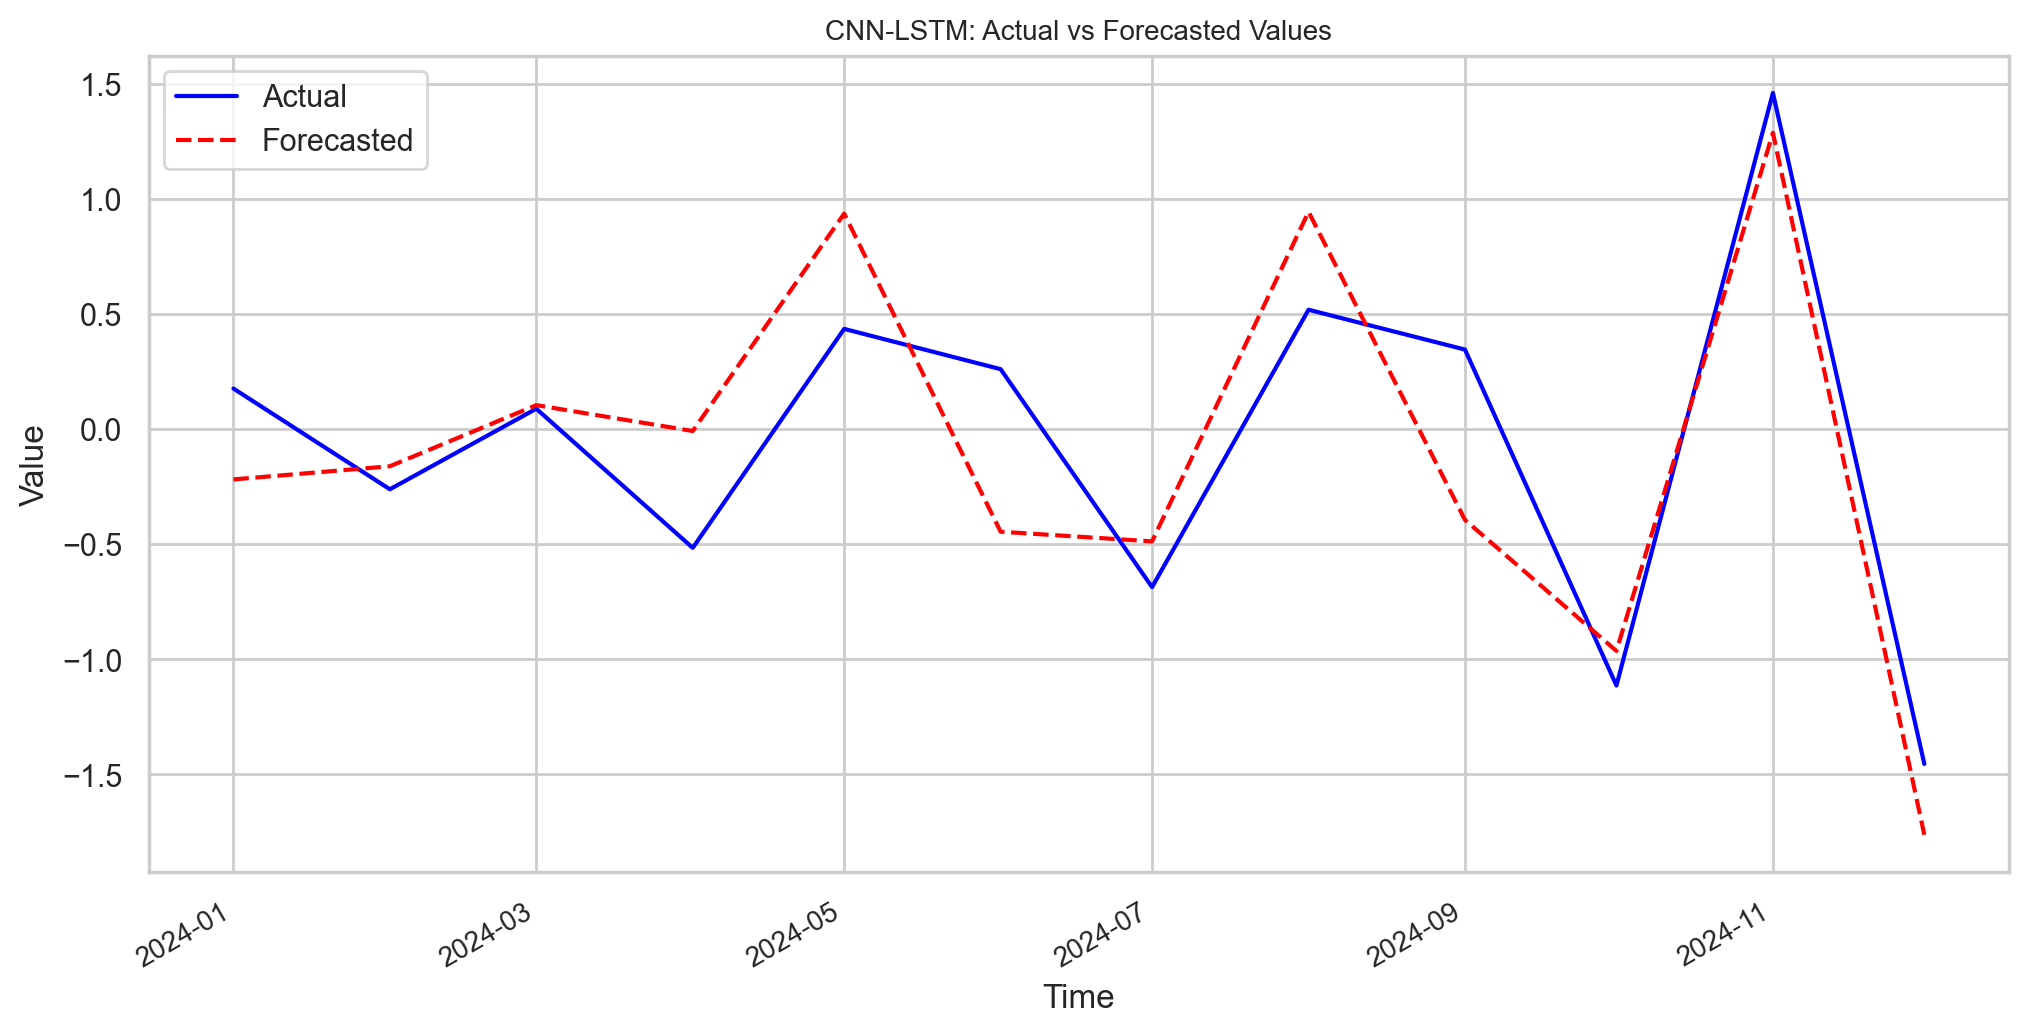

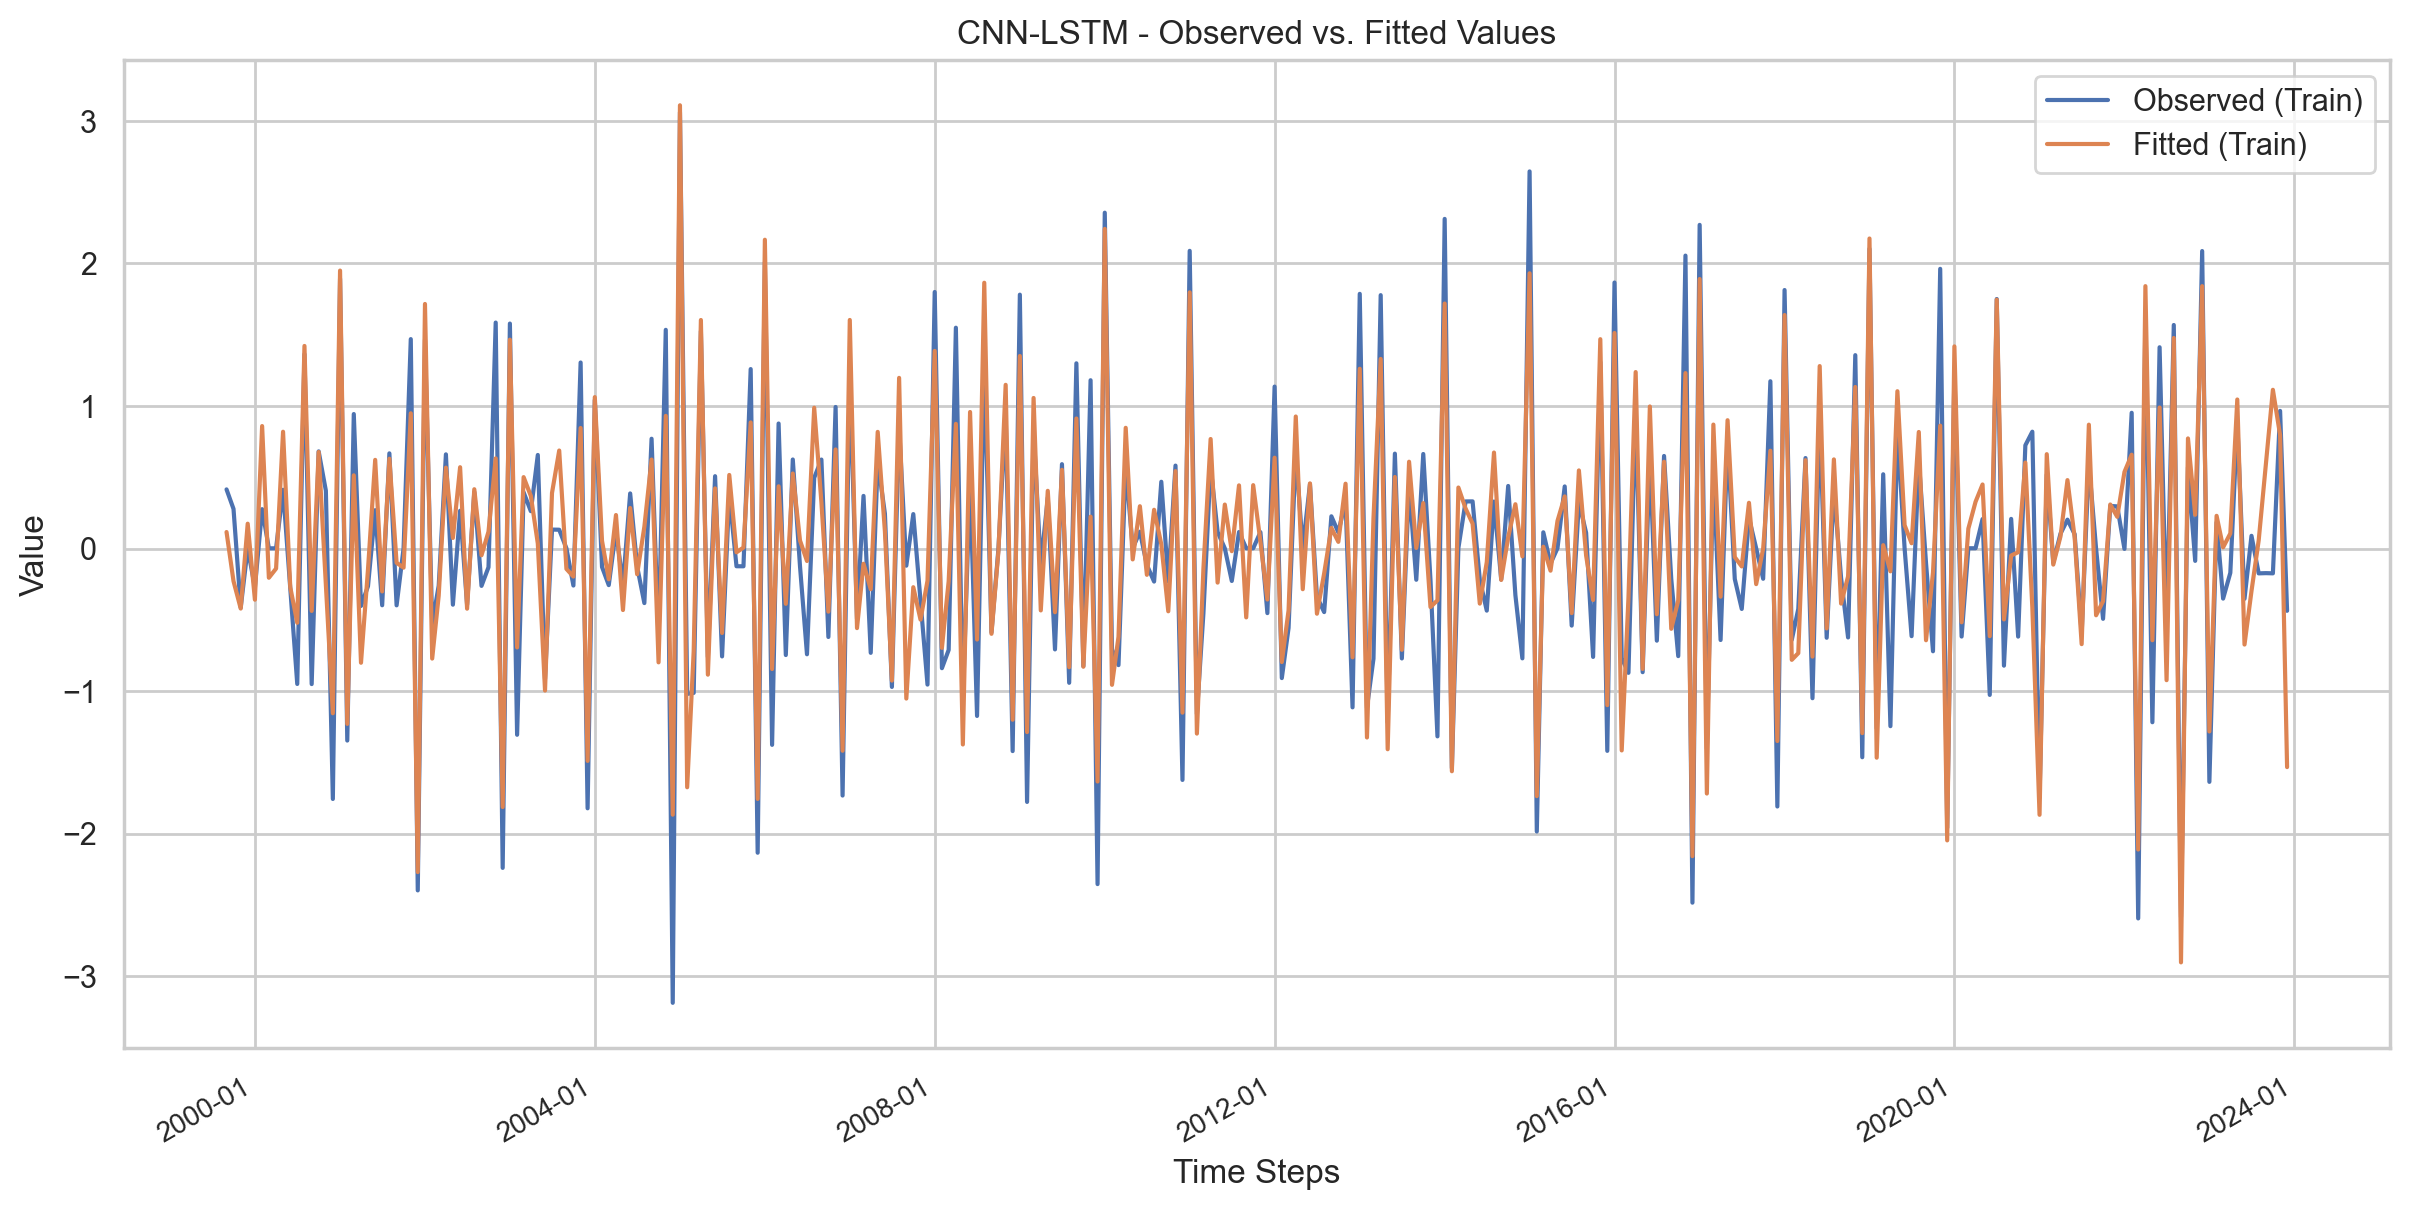

Mean Absolute Error (MAE): 0.35165468
Root Mean Squared Error (RMSE): 0.41714365


In [35]:
model, X_train, X_test, five_lags_cnn_mae, five_lags_cnn_rmse, feature_names_five_lags = cnn_lstm_model(data, test_size)

In [ ]:
print(f'CNN-LSTM + ACF/PCF LAGS (MAE): {pacf_cnn_mae}')
print(f'CNN-LSTM + ACF/PCF LAGS (RMSE): {pacf_ccnn_rmse}')
print(f'CNN-LSTM (MAE) Five Lags: {five_lags_cnn_mae}')
print(f'CNN-LSTM (RMSE) Five Lags: {five_lags_cnn_rmse}')
print(f'CNN-LSTM (MAE): {no_lags_cnn_mae}')
print(f'CNN-LSTM (RMSE): {no_lags_cnn_rmse}')
print(f'VAR (MAE): {var_mae}')
print(f'VAR (RMSE): {var_rmse}')
print(f'ARIMA (MAE): {arima_mae}')
print(f'ARIMA (RMSE): {arima_rmse}')
print(f'SARIMA (MAE): {sarima_mae}')
print(f'SARIMA (RMSE): {sarima_rmse}')

# SHAP Value Estimation for CNN-LSTM Model

In [36]:
# Wrapper function for SHAP
def model_predict(X):
    """Predict function for SHAP that ensures correct input shape."""
    X = X.reshape((X.shape[0], 1, 1, 1, X.shape[1]))  # Reshape to original model input shape
    return model.predict(X, verbose=0).flatten()  # Flatten output for SHAP

# Select a subset of X_test for SHAP analysis
def shappy(feature_names):
    # feature_names = data.drop(columns=[target]).columns.tolist()
    num_samples = min(50, X_test.shape[0])  # Ensure we don't exceed the available samples

    print("Original feature count:", len(feature_names))  # Should be 19
    print("X_test shape:", X_test.shape)  # e.g. (samples, 1, 1, 1, features)
    print("Number of features in model input:", X_test.shape[-1])  # e.g. 114?

    X_sample = X_test[:num_samples].reshape((num_samples, X_test.shape[-1]))  # Convert to 2D
    X_sample_df = pd.DataFrame(X_sample, columns=feature_names)  # Convert NumPy array back to DataFrame
    
    # Create Kernel SHAP Explainer
    explainer = shap.KernelExplainer(model_predict, X_sample_df)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_sample_df)
    
    # Create SHAP summary plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed
    shap.summary_plot(shap_values, X_sample_df, show=False)  # Prevent immediate display
    
    # Adjust font sizes
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(8)  # Change this value to your desired font size
    
    plt.show()
    return shap_values, feature_names

# Plot summary plot
# shap.summary_plot(shap_values, X_sample_df)


Original feature count: 114
X_test shape: (12, 1, 1, 1, 114)
Number of features in model input: 114


  0%|          | 0/12 [00:00<?, ?it/s]

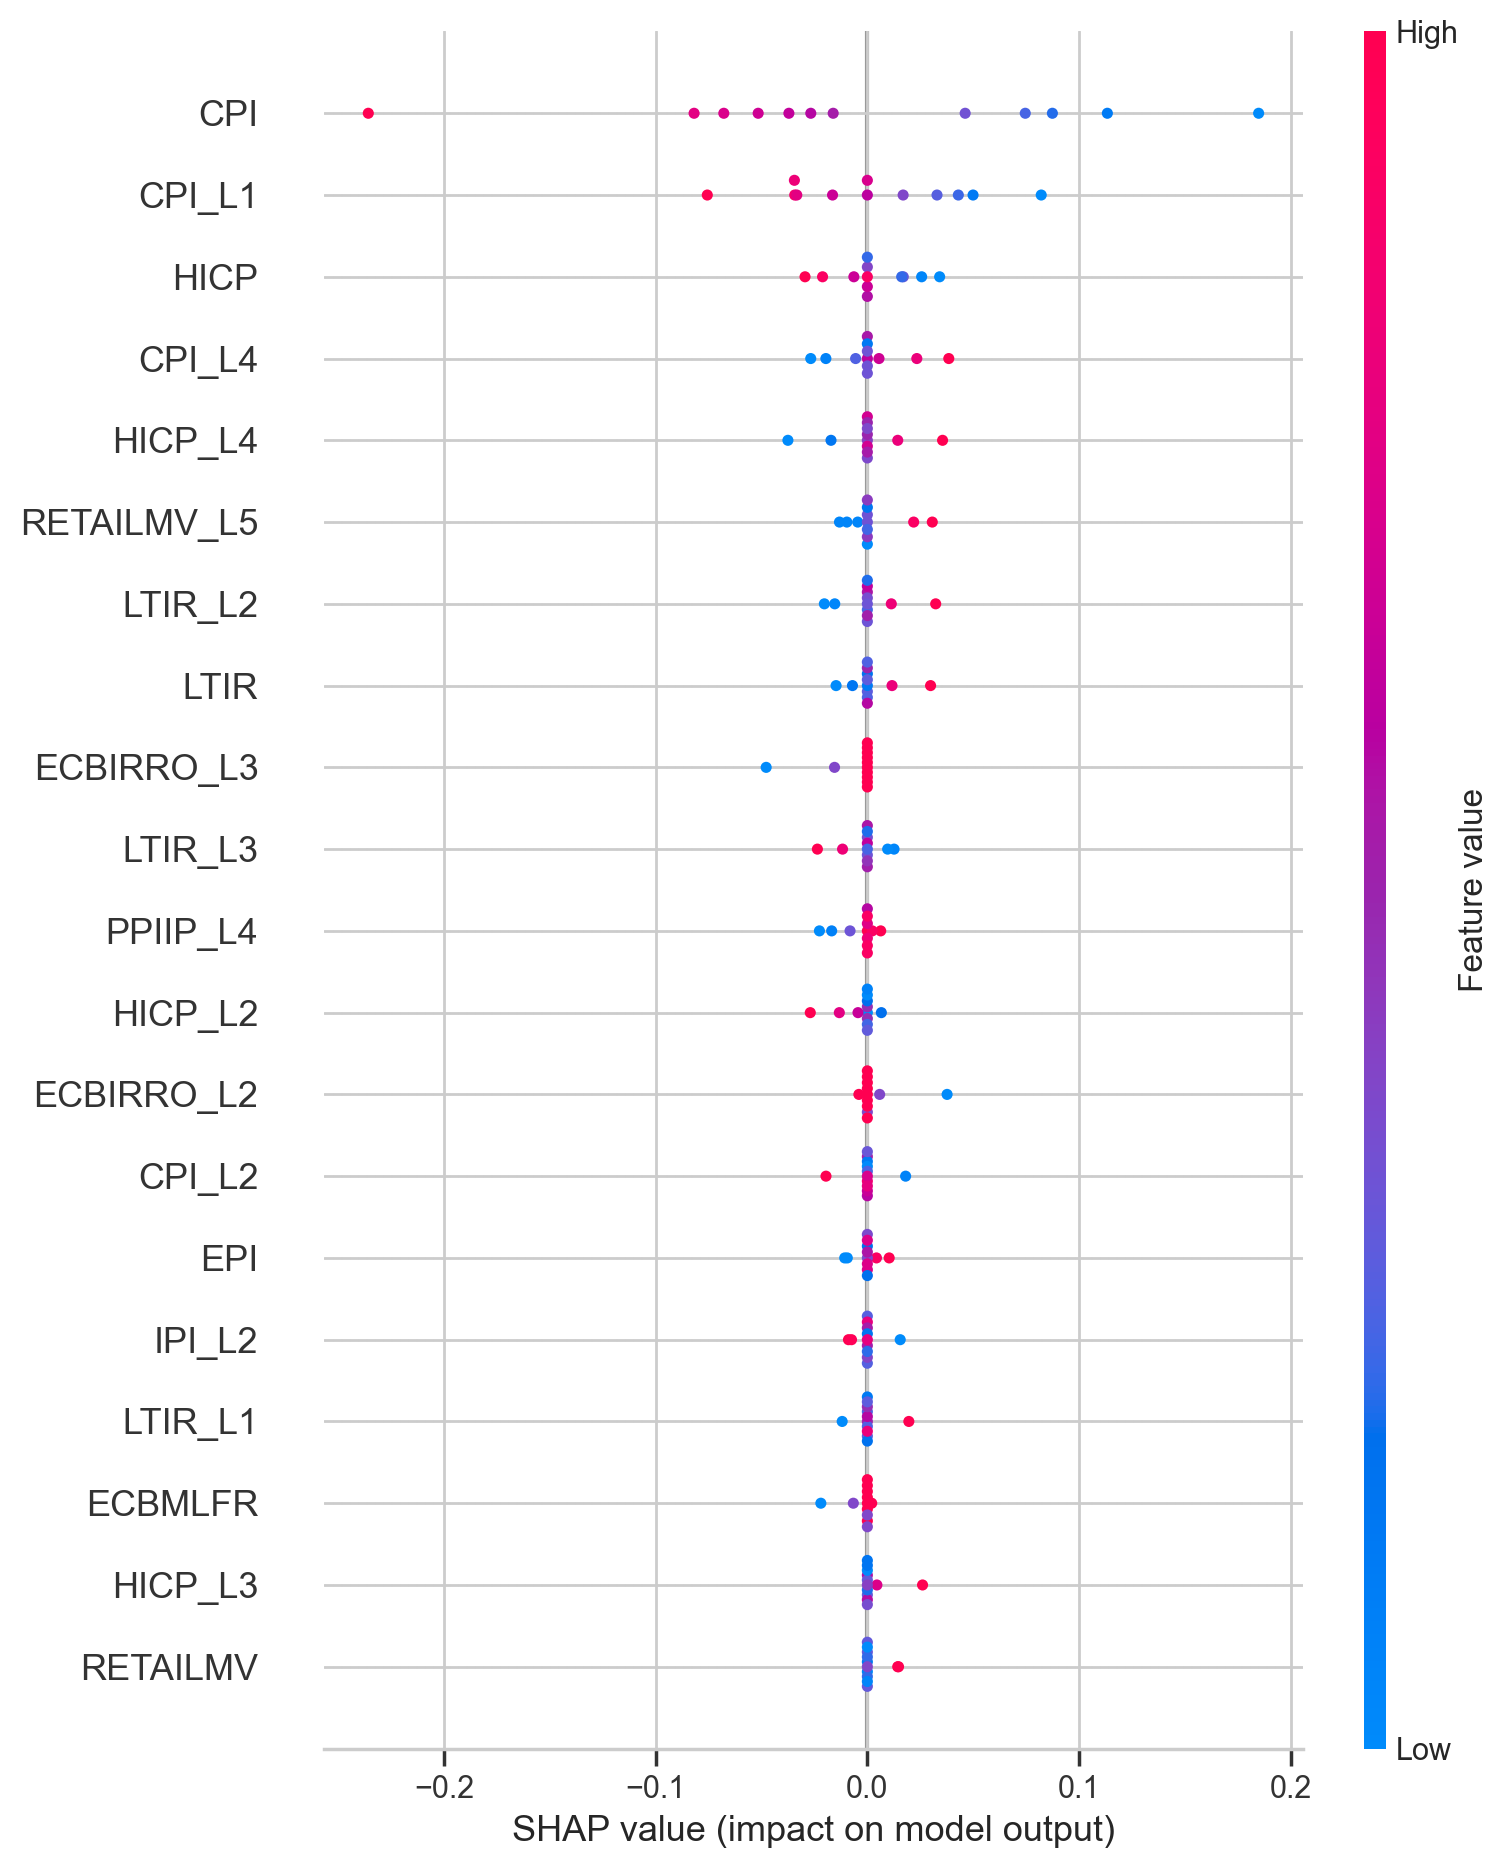

In [37]:
# print(len(data_acf_pacf.columns))
shap_values, feature_names = shappy(feature_names_five_lags)

# ***Top Influential Variables***

In [38]:
# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)

# Create a dictionary mapping feature names to their importance
shap_importance_dict = dict(zip(feature_names, shap_importance))

# Sort features by importance (descending order)
sorted_features = sorted(shap_importance_dict, key=shap_importance_dict.get, reverse=True)



In [39]:
# Convert the dictionary to a list of (feature, importance) tuples
shap_importance_list = list(shap_importance_dict.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
shap_importance_list.sort(key=lambda item: item[1], reverse=True)

# Print the sorted feature names and their importance values
print("SHAP Feature Importance (Descending Order):")
for feature, importance in shap_importance_list:
    print(f"{feature}: {importance:.4f}") # You can adjust the formatting of the importance value

SHAP Feature Importance (Descending Order):
CPI: 0.0853
CPI_L1: 0.0349
HICP: 0.0125
CPI_L4: 0.0099
HICP_L4: 0.0087
RETAILMV_L5: 0.0067
LTIR_L2: 0.0066
LTIR: 0.0053
ECBIRRO_L3: 0.0053
LTIR_L3: 0.0048
PPIIP_L4: 0.0047
HICP_L2: 0.0043
ECBIRRO_L2: 0.0040
CPI_L2: 0.0031
EPI: 0.0029
IPI_L2: 0.0027
LTIR_L1: 0.0026
ECBMLFR: 0.0026
HICP_L3: 0.0025
RETAILMV: 0.0024
IPI_L3: 0.0024
RETAILMV_L3: 0.0020
AGRPROD_L4: 0.0019
RETAILXMV_L2: 0.0018
HICP_L1: 0.0018
RETAILMV_L1: 0.0018
WPI: 0.0018
ECBIRRO_L1: 0.0015
IPI_L4: 0.0014
IPI_L1: 0.0011
RETAILXMV: 0.0009
IPI_L5: 0.0008
UNERWG_L3: 0.0007
LTIR_L4: 0.0007
AGRPROD_L2: 0.0006
HICP_L5: 0.0005
RETAILXMV_L1: 0.0005
RETAILXMV_L3: 0.0005
EPI_L3: 0.0004
PPIIP: 0.0003
ECBMLFR_L5: 0.0002
IPI: 0.0001
UNERWG: 0.0000
ECBIRRO: 0.0000
ECBDFR: 0.0000
MMR: 0.0000
RETAILGSR: 0.0000
RETAILGF: 0.0000
GOODFBT: 0.0000
AGRPROD: 0.0000
UR: 0.0000
GOODFBT_L1: 0.0000
GOODFBT_L2: 0.0000
GOODFBT_L3: 0.0000
GOODFBT_L4: 0.0000
GOODFBT_L5: 0.0000
ECBIRRO_L4: 0.0000
ECBIRRO_L5: 0.00

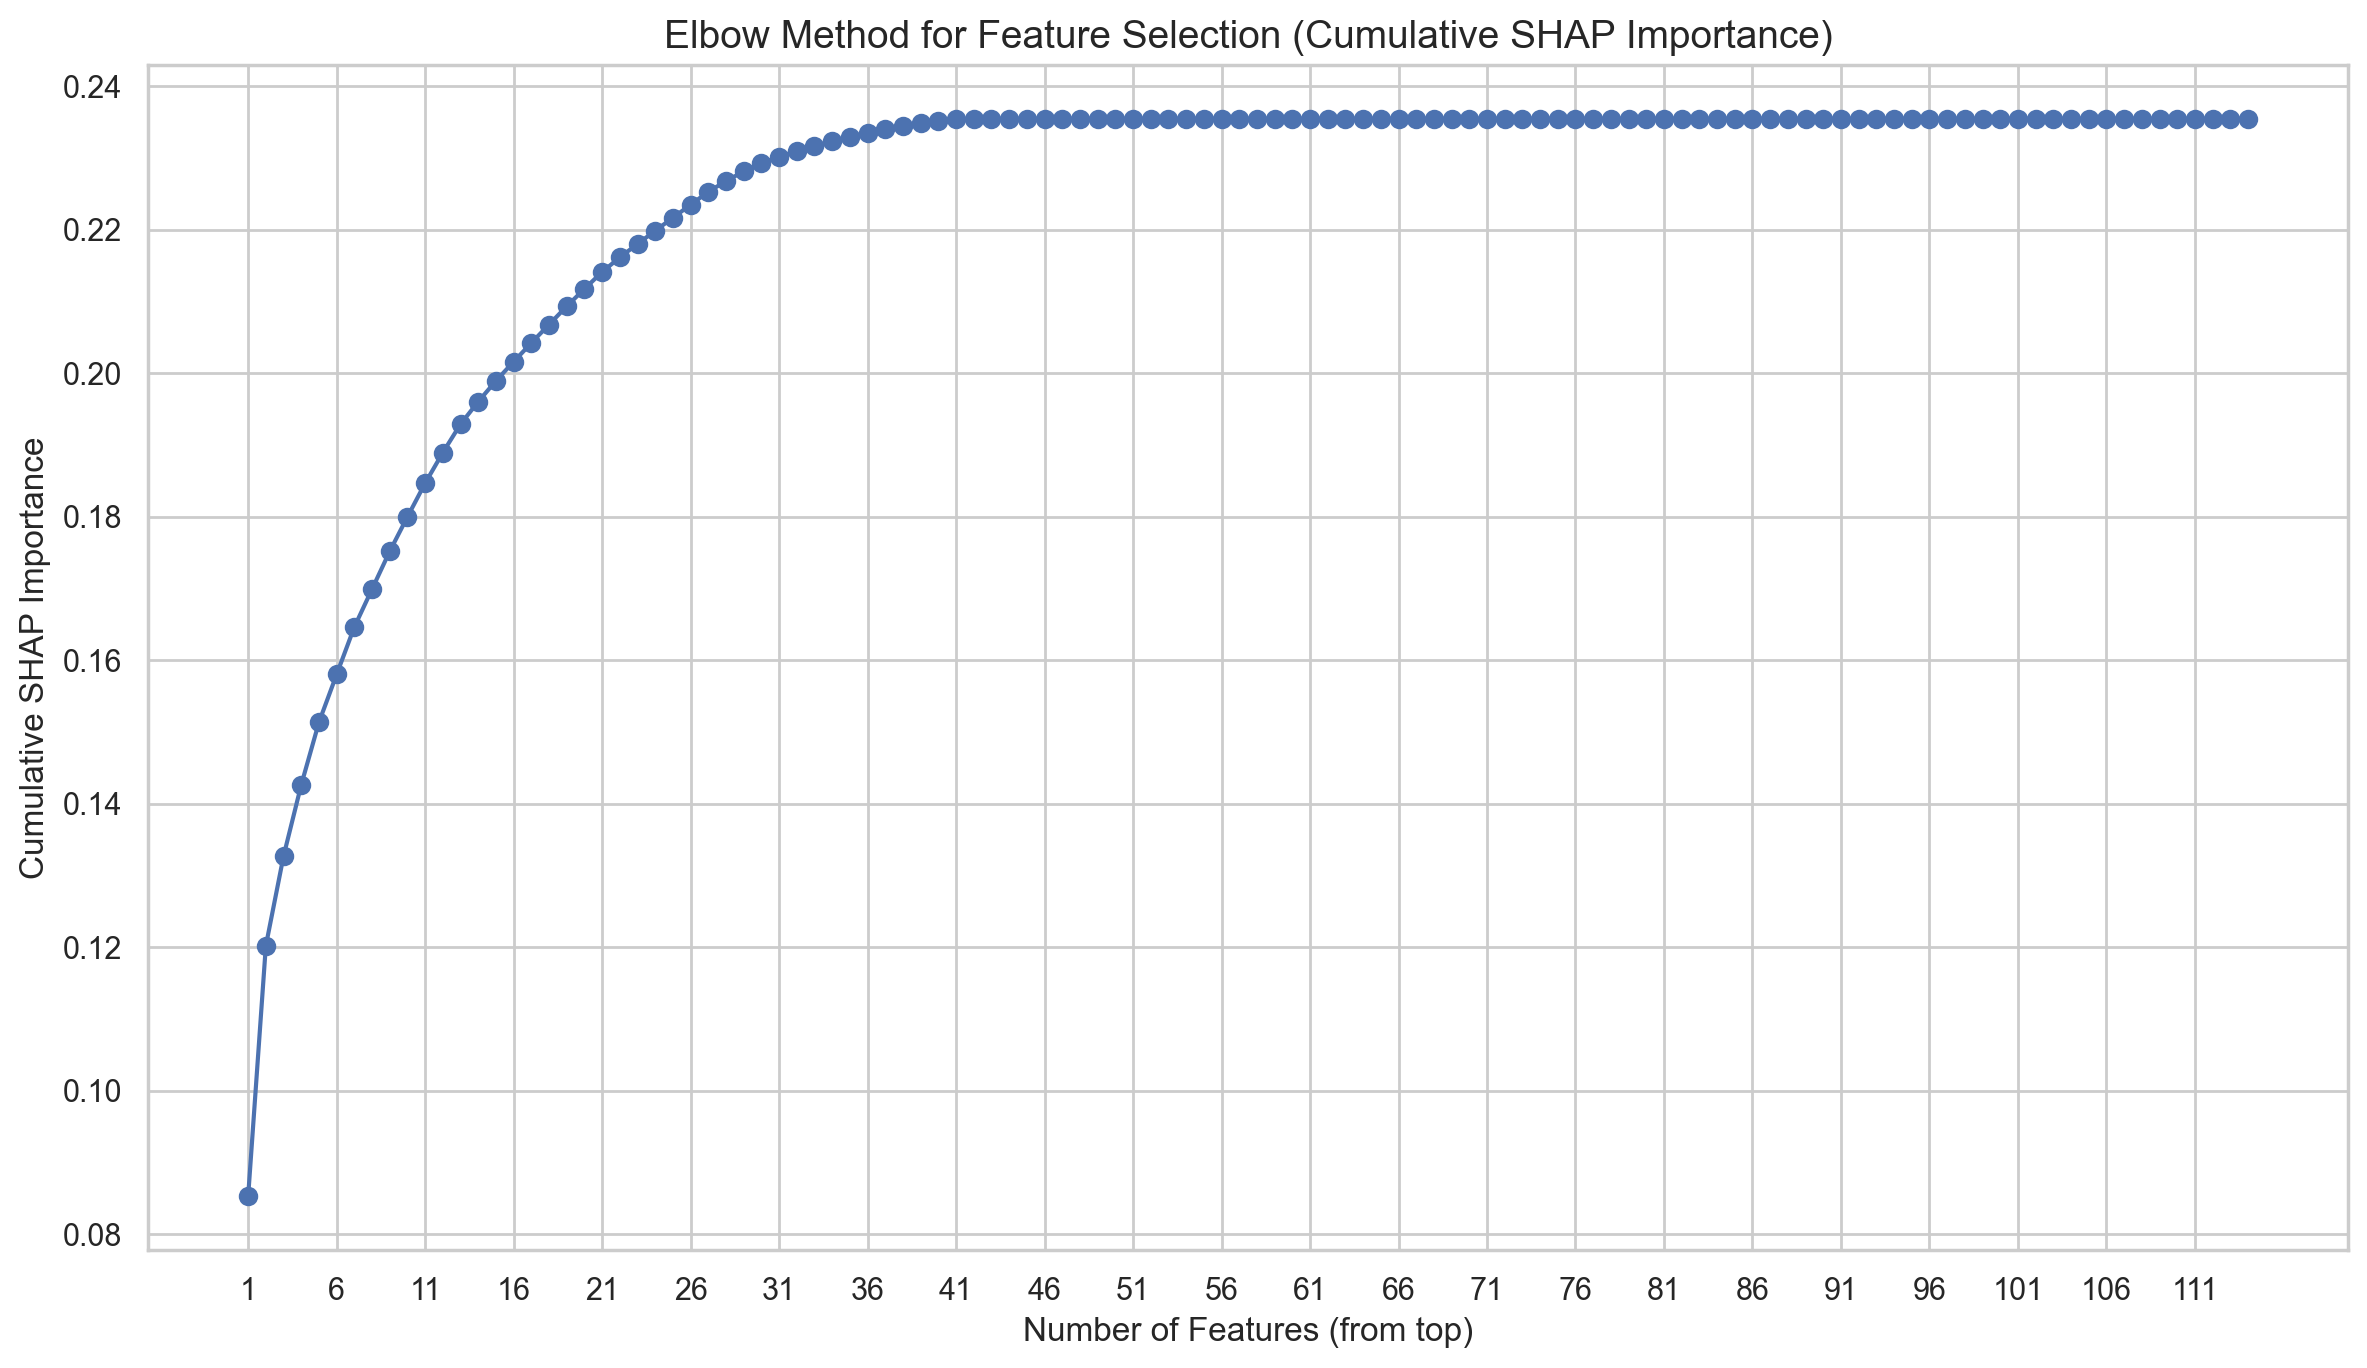

In [40]:
# Extract importance values
importance_values = [item[1] for item in shap_importance_list]

# Calculate cumulative importance
cumulative_importance = [sum(importance_values[:i+1]) for i in range(len(importance_values))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(importance_values) + 1), cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(importance_values) + 1, 5))

plt.tight_layout()
plt.show()

In [41]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
# one_third = len(sorted_features) // 3
top_influential_variables = np.array(sorted_features)[:31]

# Print the top influential variables
print("*** Top 13 influential variables based on elbow ***")
print(top_influential_variables)
print("*** All variables sorted in order of influence ***")
print(sorted_features)

*** Top 13 influential variables based on elbow ***
['CPI' 'CPI_L1' 'HICP' 'CPI_L4' 'HICP_L4' 'RETAILMV_L5' 'LTIR_L2' 'LTIR'
 'ECBIRRO_L3' 'LTIR_L3' 'PPIIP_L4' 'HICP_L2' 'ECBIRRO_L2' 'CPI_L2' 'EPI'
 'IPI_L2' 'LTIR_L1' 'ECBMLFR' 'HICP_L3' 'RETAILMV' 'IPI_L3' 'RETAILMV_L3'
 'AGRPROD_L4' 'RETAILXMV_L2' 'HICP_L1' 'RETAILMV_L1' 'WPI' 'ECBIRRO_L1'
 'IPI_L4' 'IPI_L1' 'RETAILXMV']
*** All variables sorted in order of influence ***
['CPI', 'CPI_L1', 'HICP', 'CPI_L4', 'HICP_L4', 'RETAILMV_L5', 'LTIR_L2', 'LTIR', 'ECBIRRO_L3', 'LTIR_L3', 'PPIIP_L4', 'HICP_L2', 'ECBIRRO_L2', 'CPI_L2', 'EPI', 'IPI_L2', 'LTIR_L1', 'ECBMLFR', 'HICP_L3', 'RETAILMV', 'IPI_L3', 'RETAILMV_L3', 'AGRPROD_L4', 'RETAILXMV_L2', 'HICP_L1', 'RETAILMV_L1', 'WPI', 'ECBIRRO_L1', 'IPI_L4', 'IPI_L1', 'RETAILXMV', 'IPI_L5', 'UNERWG_L3', 'LTIR_L4', 'AGRPROD_L2', 'HICP_L5', 'RETAILXMV_L1', 'RETAILXMV_L3', 'EPI_L3', 'PPIIP', 'ECBMLFR_L5', 'IPI', 'UNERWG', 'ECBIRRO', 'ECBDFR', 'MMR', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'UR', '

# ***CNN-LSTM + Variable Selection***

In [42]:

# Add the target variable to the list of influential variables
top_influential_variables = np.append(top_influential_variables, target)
data_iv = data_acf_pacf[top_influential_variables]


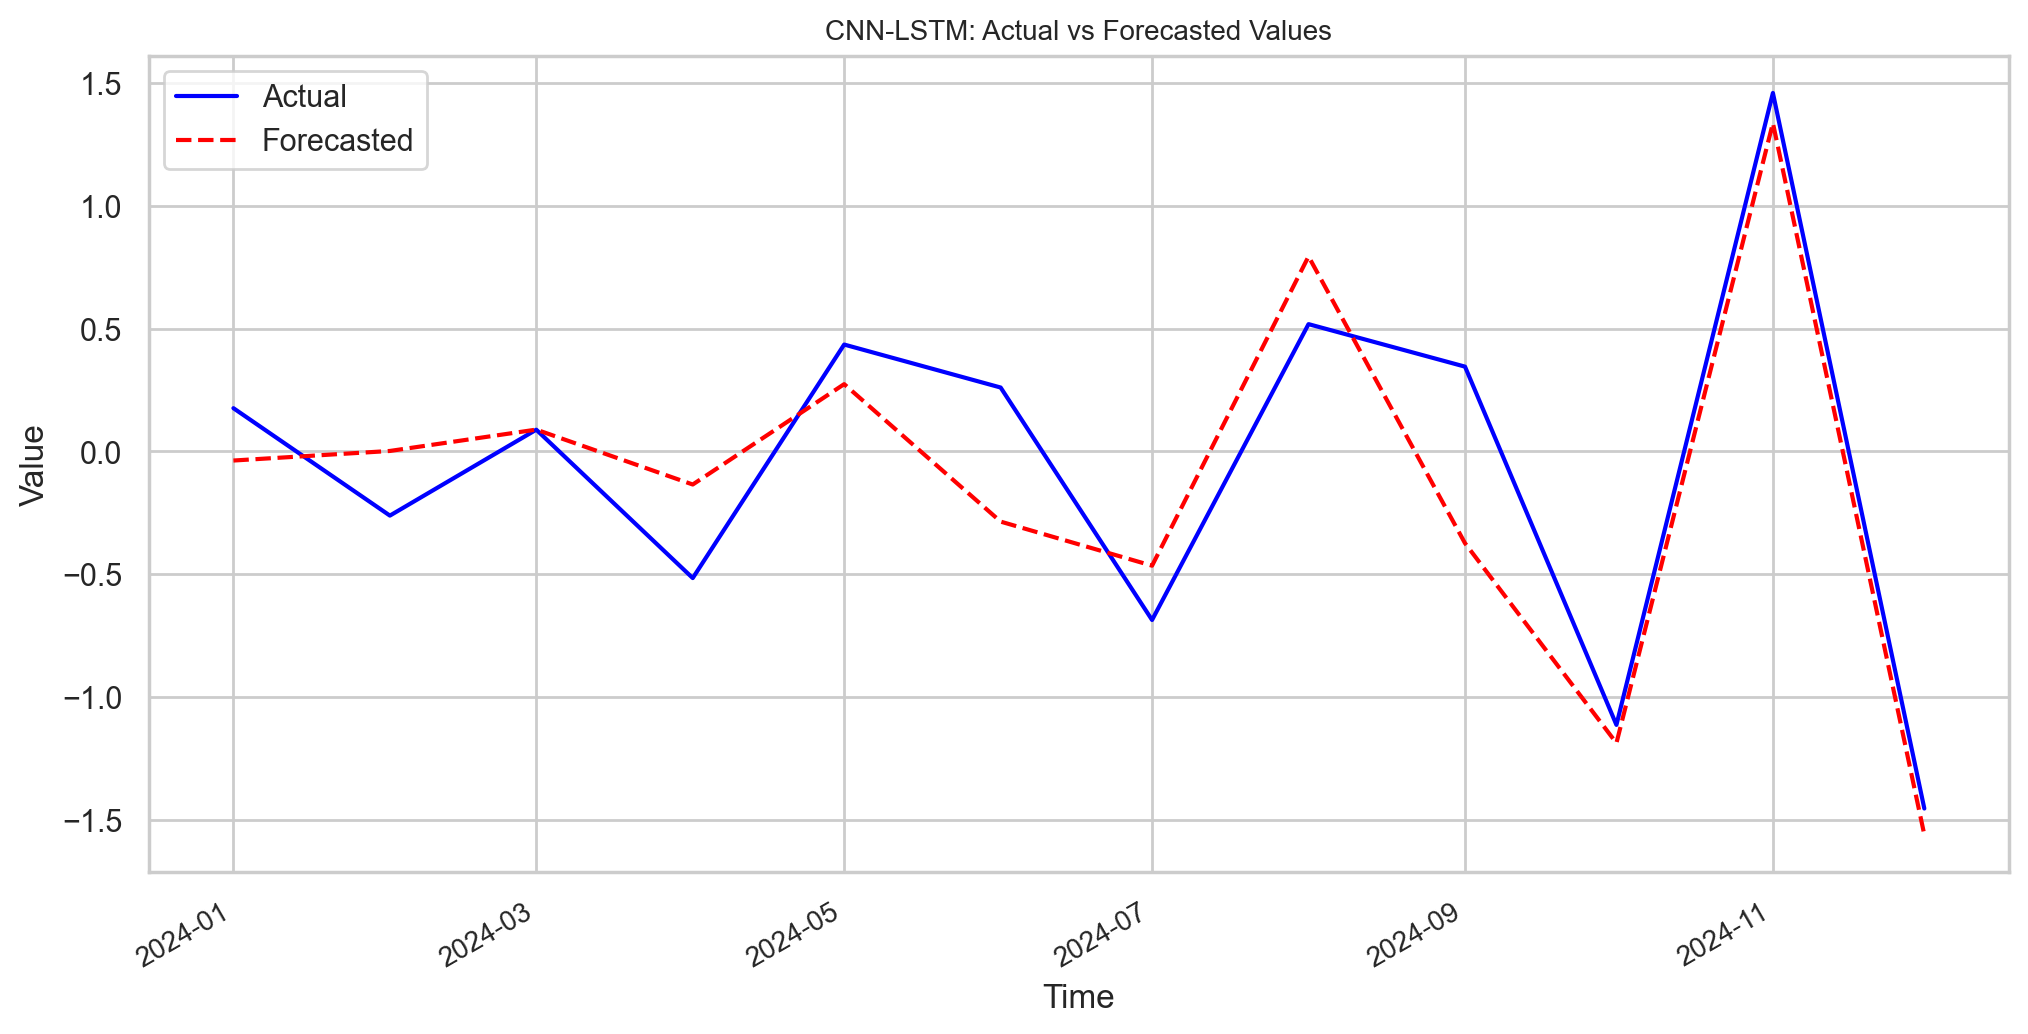

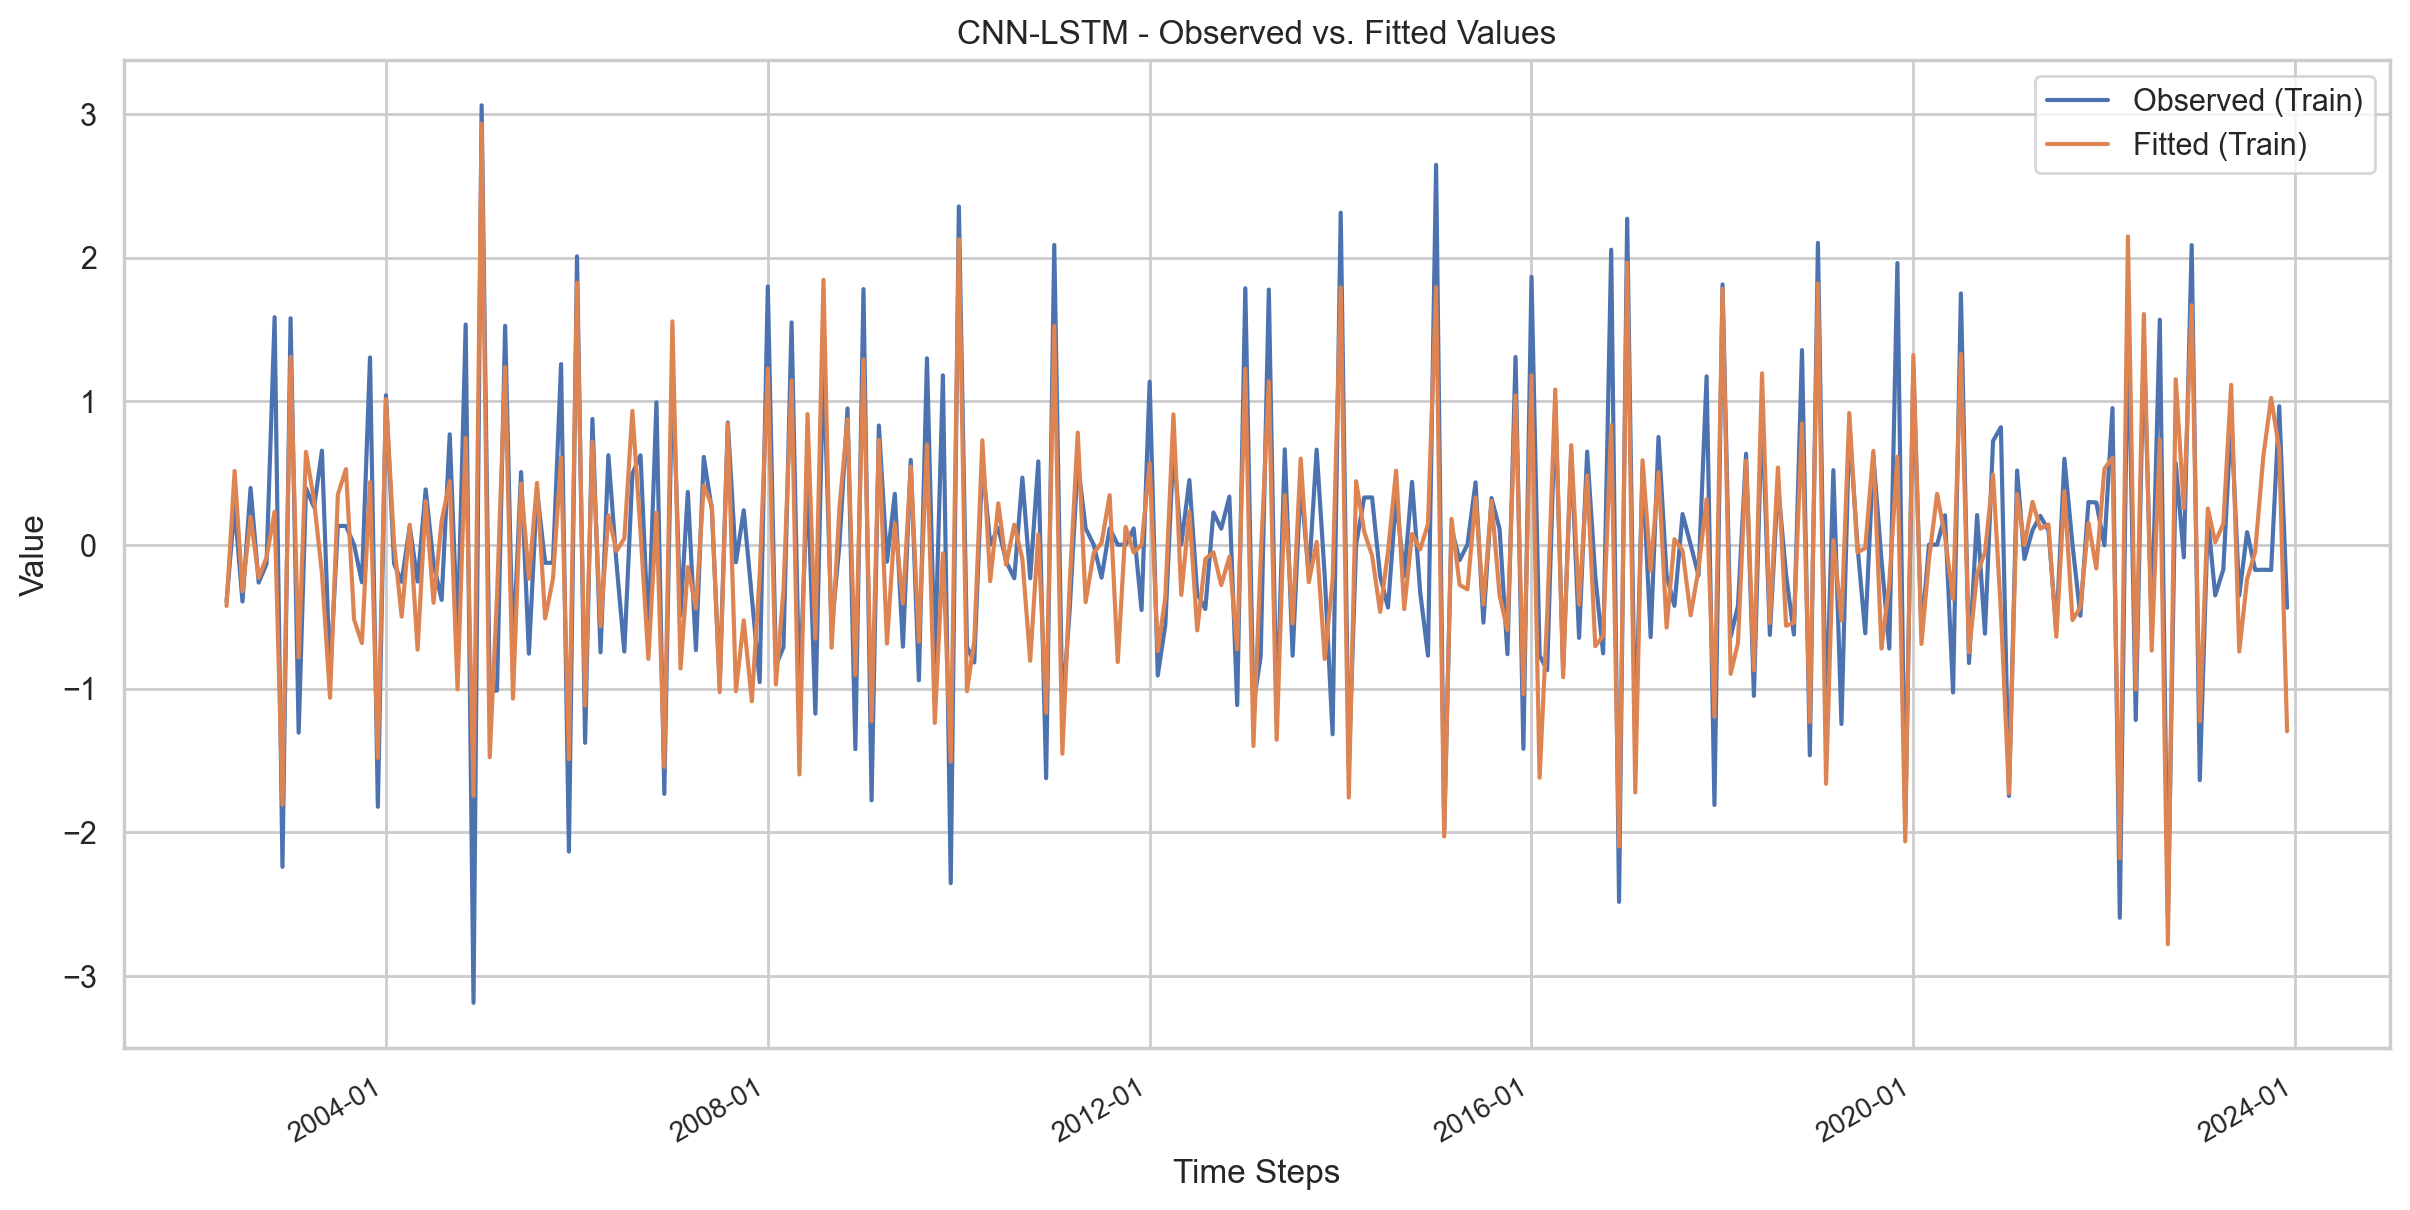

Mean Absolute Error (MAE): 0.25712033
Root Mean Squared Error (RMSE): 0.32387538


In [43]:
model_var_sel, X_train_var_sel, X_test_var_sel, cnn_mae_var_sel, cnn_rmse_var_sel, feature_names_var_sel = cnn_lstm_model(data_iv, test_size)


# CNN-LSTM + VAE

In [44]:

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
            reconstruction_loss = mse(data, reconstruction)
            # mse = tf.keras.losses.MeanSquaredError()
            # reconstruction_loss = mse(data, reconstruction)

            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def build_vae(input_dim, latent_dim=7):
    # Encoder
    encoder_inputs = Input(shape=(input_dim,))
    x = layers.Dense(64, activation="selu")(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="selu")(latent_inputs)
    decoder_outputs = layers.Dense(input_dim, activation="selu")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # VAE Model
    vae = VAE(encoder, decoder)
    vae.compile(optimizer="adam")
    return vae, encoder


In [45]:
# # 1. Extract raw features (no lagging yet)
# X_vae = data.copy().drop(columns=['CPI'])
# y_target = data['CPI']
#
# # 2. Scale & run VAE (as you already have)
# vae, encoder = build_vae(X_vae.shape[1], latent_dim=5)
# vae.fit(X_vae, X_vae, epochs=50, batch_size=32)
# _, _, z_encoded = encoder.predict(X_vae)
#
# # 3. Combine compressed features + target
# compressed_df = pd.DataFrame(z_encoded, columns=[f'z{i+1}' for i in range(z_encoded.shape[1])], index=data.index)
# compressed_df['CPI'] = y_target.values
#
# # 4. Apply lagging
# data_ls_compressed = create_lag_features(compressed_df, columns=compressed_df.columns, lags=3)
# data_ls_compressed.dropna(inplace=True)

def prepare_vae_data(data):
    # 1. Extract raw features (no lagging yet)
    X_vae = data.copy().drop(columns=[target])
    y_target = data[target]

    # 2. Scale & run VAE (as you already have)
    vae, encoder = build_vae(X_vae.shape[1], latent_dim=7)
    vae.fit(X_vae, X_vae, epochs=50, batch_size=32, verbose=0)

    # print("Input to VAE:", X_vae.shape)
    # print(f"Any NaNs? {np.isnan(X_vae).any()}")
    # print(f"Any infs? {np.isinf(X_vae).any()}")
    # assert X_vae.shape[0] > 0 and X_vae.shape[1] > 0, f"X_vae shape is {X_vae.shape}"

    _, _, z_encoded = encoder.predict(X_vae)

    # 3. Combine compressed features + target
    compressed_df = pd.DataFrame(z_encoded, columns=[f'z{i+1}' for i in range(z_encoded.shape[1])], index=data.index)
    compressed_df[target] = y_target.values

    # 4. Apply lagging
    # data_ls_compressed = create_lag_features(compressed_df.copy(), columns=compressed_df.columns, lags=3)
    # data_ls_compressed.dropna(inplace=True)

    return compressed_df


In [ ]:
data_comp = prepare_vae_data(data_m)

In [ ]:
model_vae_1, X_train_vae_1, X_test_vae_1, cnn_mae_vae, cnn_rmse_vae, fnames = cnn_lstm_model(data_comp, test_size)


# All results including CNN-LSTM + Variable Selection (VarSel)
For one sample run

In [ ]:
print(f'CNN-LSTM + ACF/PCF LAGS (MAE): {pacf_cnn_mae}')
print(f'CNN-LSTM + ACF/PCF LAGS (RMSE): {pacf_ccnn_rmse}')
print(f'CNN-LSTM (MAE) Five Lags: {five_lags_cnn_mae}')
print(f'CNN-LSTM (RMSE) Five Lags: {five_lags_cnn_rmse}')
print(f'CNN-LSTM (MAE): {no_lags_cnn_mae}')
print(f'CNN-LSTM (RMSE): {no_lags_cnn_rmse}')
print(f'CNN-LSTM + VAE (MAE): {cnn_mae_vae}')
print(f'CNN-LSTM + VAE (RMSE): {cnn_rmse_vae}')
print(f'CNN-LSTM + SHAP (MAE): {cnn_mae_var_sel}')
print(f'CNN-LSTM + SHAP (RMSE): {cnn_rmse_var_sel}')
print(f'VAR (MAE): {var_mae}')
print(f'VAR (RMSE): {var_rmse}')
print(f'ARIMA (MAE): {arima_mae}')
print(f'ARIMA (RMSE): {arima_rmse}')
print(f'SARIMA (MAE): {sarima_mae}')
print(f'SARIMA (RMSE): {sarima_rmse}')


# ***Robust Test***

# ***ALL Models***

In [73]:


def train_and_evaluate_arima_model(data, auto_arima_model, title='ARIMA: Observed vs Fitted', target_column=target, test_size=test_size):

    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series
    train_series = train_df[target_column]
    test_series = test_df[target_column]

    arima_model = ARIMA(train_series.tolist(), order=auto_arima_model.order)
    model_fit = arima_model.fit()

    # Forecast `forecast_horizon` steps ahead (recursive)
    forecast = model_fit.forecast(steps=test_size)

    # Build output DataFrame
    forecast_index = test_series.index[:test_size]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=[target])
    actual_series = test_series.iloc[:test_size]

    # Metrics
    mae = mean_absolute_error(actual_series, forecast_df[target])
    rmse = np.sqrt(mean_squared_error(actual_series, forecast_df[target]))
    abs_error = np.abs(actual_series.values - forecast_df[target].values)
    return mae, rmse, abs_error


def train_eval_cnn_lstm_model(data, test_size=test_size):
    """Main function to execute the pipeline."""
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used = prepare_data(data, target, test_size=test_size)
    model = build_model((1, 1, 1, X_train.shape[-1]))
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    y_test_actual = inverse_transform(scaler_y, y_test)
    predictions_actual = inverse_transform(scaler_y, predictions)

    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    abs_error = np.abs(y_test_actual.flatten() - predictions_actual.flatten())
    return mae, rmse, abs_error


def train_and_evaluate_var_model(data, lag_order, test_size):

    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Fit the VAR model
    model = VAR(train_df)
    var_model = model.fit(lag_order)

    input_data = train_df.values[-lag_order:]
    forecast = var_model.forecast(y=input_data, steps=test_size)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast, columns=train_df.columns, index=test_df.index)

    # Extract actual and forecasted values for CPI
    actual_cpi = test_df[target]
    forecasted_cpi = forecast_df[target]

    # Compute evaluation metrics
    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))
    var_abs_error = np.abs(actual_cpi.values - forecasted_cpi.values)
    return mae, rmse, var_abs_error


def train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size, target_column=target):

    # Extract target series for SARIMA
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]

    # Extract target series for SARIMA
    train_cpi_arima = train_df[target_column]
    test_cpi_arima = test_df[target_column]

    # Ensure the index is datetime for proper date manipulation
    train_cpi_arima.index = pd.to_datetime(train_cpi_arima.index)

    history = train_cpi_arima.tolist()
    sarima_model = SARIMAX(history,
                           order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output
    forecast = sarima_model_fit.forecast(steps=test_size)
    forecast_df = pd.DataFrame(forecast, index=test_cpi_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpi_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpi_arima, forecast_df[target_column]))
    forecasted_cpi = forecast_df[target_column]
    abs_error = np.abs(test_cpi_arima.values - forecasted_cpi.values)
    return mae_sarima, rmse_sarima, abs_error


# 100 Subsample run

In [47]:
series_name = "dfCPI_full_dataset_subsample"


# Column Definitions

In [48]:
main_vars_ex_lags = main_vars.copy()
main_vars_plus_5lags = data.columns.tolist()
main_vars_plus_cpi_acf_pcf_lags = data_acf_pacf.columns.tolist()
test_size = 12

Error Arrays

In [74]:
var_maes = []
var_rmses = []
var_all_forecasts = []

arima_maes = []
arima_rmses = []
arima_all_forecasts = []

sarima_maes = []
sarima_rmses = []
sarima_all_forecasts = []

cnn_maes = []
cnn_rmses = []
cnn_all_predictions = []

cnn_5lags_maes = []
cnn_5lags_rmses = []
cnn_5lags_all_predictions = []

cnn_acf_pacf_lags_maes = []
cnn_acf_pacf_lags_rmses = []
cnn_acf_pacf_all_lags_predictions = []

cnn_shap_maes = []
cnn_shap_rmses = []
cnn_shap_all_predictions = []

# cnn_vae_maes = []
# cnn_vae_rmses = []
# cnn_vae_all_predictions = []


In [50]:
# Pre-load all data
all_data_dict = {}
print("Loading all CSVs into memory...")
for i in tqdm(range(100), desc="Loading data"):
    filename = f"{series_name}_{i + 1}.csv"
    file_path = os.path.join(all_LagsCPI_Dir, filename)
    df = pd.read_csv(file_path)
    df.set_index('DATE', inplace=True)
    all_data_dict[i + 1] = df
print("All CSVs loaded.\n")

Loading all CSVs into memory...


Loading data: 100%|██████████| 100/100 [00:00<00:00, 254.97it/s]

All CSVs loaded.



In [75]:

for i in tqdm(range(1), desc="Processing models"):
    # filename = f"{series_name}_{i + 1}.csv"
    # file_path = os.path.join(all_LagsCPI_Dir, filename)
    # data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = all_data_dict[i + 1]
    base_data = data[main_vars_ex_lags]

    # VAR
    var_mae, var_rmse, var_forecasted_cpi = train_and_evaluate_var_model(base_data, var_lag_order, test_size=test_size)
    var_maes.append(var_mae)
    var_rmses.append(var_rmse)
    var_all_forecasts.append(var_forecasted_cpi)

    # ARIMA
    arima_mae, arima_rmse, arima_forecasted = train_and_evaluate_arima_model(base_data, auto_arima_model_arima, test_size=test_size)
    arima_maes.append(arima_mae)
    arima_rmses.append(arima_rmse)
    arima_all_forecasts.append(arima_forecasted)

    # SARIMA
    sarima_mae, sarima_rmse, sarima_forecasted_cpi = train_and_evaluate_sarima_model(base_data, auto_arima_model_sarima, test_size, target_column=target)
    sarima_maes.append(sarima_mae)
    sarima_rmses.append(sarima_rmse)
    sarima_all_forecasts.append(sarima_forecasted_cpi)

    # CNN-LSTM BASE
    cnn_mae, cnn_rmse, cnn_predictions = train_eval_cnn_lstm_model(base_data, test_size=test_size)
    cnn_maes.append(cnn_mae)
    cnn_rmses.append(cnn_rmse)
    cnn_all_predictions.append(cnn_predictions)

    # CNN-LSTM 5 lags
    cnn_5lags_data = data[main_vars_plus_5lags]
    cnn_5_lags_mae, cnn_5lags_rmse, cnn_5lags_predictions = train_eval_cnn_lstm_model(cnn_5lags_data, test_size=test_size)
    cnn_5lags_maes.append(cnn_5_lags_mae)
    cnn_5lags_rmses.append(cnn_5lags_rmse)
    cnn_5lags_all_predictions.append(cnn_5lags_predictions)

    # CNN-LSTM 5 lags
    cnn_acf_pacf_lags_data = data[main_vars_plus_cpi_acf_pcf_lags]
    cnn_acf_pacf_lags_mae, cnn_acf_pacf_lags_rmse, cnn_acf_pacf_lags_prediction = train_eval_cnn_lstm_model(cnn_acf_pacf_lags_data, test_size=test_size)
    cnn_acf_pacf_lags_maes.append(cnn_acf_pacf_lags_mae)
    cnn_acf_pacf_lags_rmses.append(cnn_acf_pacf_lags_rmse)
    cnn_acf_pacf_all_lags_predictions.append(cnn_acf_pacf_lags_prediction)

    # CNN-LSTM SHAP vars
    cnn_shap_data = data[top_influential_variables]
    cnn_shap_mae, cnn_shap_rmse, cnn_shap_predictions = train_eval_cnn_lstm_model(cnn_shap_data, test_size=test_size)
    cnn_shap_maes.append(cnn_shap_mae)
    cnn_shap_rmses.append(cnn_shap_rmse)
    cnn_shap_all_predictions.append(cnn_shap_predictions)



    # # CNN-LSTM VAE
    # vae_data_comp = prepare_vae_data(base_data)
    # cnn_vae_mae, cnn_vae_rmse, cnn_vae_predictions = train_eval_cnn_lstm_model(vae_data_comp, test_size=test_size)
    # cnn_vae_maes.append(cnn_vae_mae)
    # cnn_vae_rmses.append(cnn_vae_rmse)
    # cnn_vae_all_predictions.append(cnn_vae_predictions)



Processing models: 100%|██████████| 1/1 [01:38<00:00, 98.21s/it]


# Save Results

In [79]:
print("VAR")
print(np.mean(var_all_forecasts[0]))
print("CNN 5 lags")
print(np.mean(cnn_5lags_all_predictions[0]))
print("SARIMA")
print(np.mean(sarima_all_forecasts[0]))
print("ARIMA")
print(np.mean(arima_all_forecasts[0]))
print("CNN ACF PACF")
print(np.mean(cnn_acf_pacf_all_lags_predictions[0]))
print("CNN SHAP")
print(np.mean(cnn_shap_all_predictions[0]))
print("CNN ALL")
print(np.mean(cnn_all_predictions[0]))


VAR
0.7569484128076681
CNN 5 lags
0.3331742682742119
SARIMA
0.5152862450570178
ARIMA
0.8765101298620489
CNN ACF PACF
0.33222913115930947
CNN SHAP
0.4049965882197741
CNN ALL
0.7930328680410187


In [54]:

# Directory to save output
output_dir = "model_results"
os.makedirs(output_dir, exist_ok=True)

# Model data
model_results = {
    "VAR": (var_maes, var_rmses, var_all_forecasts),
    "ARIMA": (arima_maes, arima_rmses, arima_all_forecasts),
    "SARIMA": (sarima_maes, sarima_rmses, sarima_all_forecasts),
    "CNN": (cnn_maes, cnn_rmses, cnn_all_predictions),
    "CNN_5LAGS": (cnn_5lags_maes, cnn_5lags_rmses, cnn_5lags_all_predictions),
    "CNN_ACF_PACF": (cnn_acf_pacf_lags_maes, cnn_acf_pacf_lags_rmses, cnn_acf_pacf_all_lags_predictions),
    "CNN_SHAP": (cnn_shap_maes, cnn_shap_rmses, cnn_shap_all_predictions),
}

# Save MAEs
mae_df = pd.DataFrame({model: maes for model, (maes, _, _) in model_results.items()})
mae_df.index.name = "Iteration"
mae_df.to_csv(os.path.join(output_dir, "all_mae.csv"))

# Save RMSEs
rmse_df = pd.DataFrame({model: rmses for model, (_, rmses, _) in model_results.items()})
rmse_df.index.name = "Iteration"
rmse_df.to_csv(os.path.join(output_dir, "all_rmse.csv"))

# Save Forecasts (wide format)
forecast_wide = pd.DataFrame()
for model, (_, _, forecasts) in model_results.items():
    forecasts_array = np.squeeze(np.array(forecasts))
    col_names = [f"{model}_step{i+1}" for i in range(forecasts_array.shape[1])]
    forecast_df = pd.DataFrame(forecasts_array, columns=col_names)
    forecast_wide = pd.concat([forecast_wide, forecast_df], axis=1)

forecast_wide.index.name = "Iteration"
forecast_wide.to_csv(os.path.join(output_dir, "all_forecasts.csv"))

# # Optional: Save Forecasts (long format)
# long_format_records = []
# for model, (_, _, forecasts) in model_results.items():
#     for i, forecast in enumerate(forecasts):  # i = iteration index
#         for j, value in enumerate(forecast):  # j = time step
#             long_format_records.append({
#                 "Iteration": i,
#                 "Model": model,
#                 "Step": j + 1,
#                 "Forecast": value
#             })

# forecast_long_df = pd.DataFrame(long_format_records)
# forecast_long_df.to_csv(os.path.join(output_dir, "all_forecasts_long.csv"), index=False)


In [ ]:
print()

# ***VAR***

# ***SARIMA***

 # ***CNN-LSTM Base***

# CNN-LSTM 5 lags

# CNN-LSTM With ACF/PACF lags

# ***CNN-LSTM + Variable Selection***

In [ ]:
# avg_sarima_mae = np.mean(var_maes)
# avg_sarima_rmse = np.mean(var_rmses)
print(f'CNN-LSTM + VAE Average MAE: {avg_cnn_vae_mae}')
print(f'CNN-LSTM + VAE Average RMSE: {avg_cnn_vae_rmse}')
print(f'CNN-LSTM + VS Average MAE: {cnn_sel_avg_mae}')
print(f'CNN-LSTM + VS Selection Average RMSE: {cnn_sel_avg_rmse}')
print(f'CNN-LSTM Average MAE: {avg_cnn_mae}')
print(f'CNN-LSTM Average RMSE: {avg_cnn_rmse}')
print(f'ARIMA Average MAE: {avg_arima_mae}')
print(f'ARIMA Average RMSE: {avg_arima_rmse}')
print(f'VAR Average MAE: {avg_var_mae}')
print(f'VAR Average RMSE: {avg_var_rmse}')
print(f'SARIMA Average MAE: {avg_sarima_mae}')
print(f'SARIMA Average RMSE: {avg_sarima_rmse}')

# print(f'Average RMSE: {avg_sarima_rmse}')


CNN-LSTM + VAE Average MAE: 0.5393014362022318
CNN-LSTM + VAE Average RMSE: 0.6787154713028031
CNN-LSTM + VAR Selection Average MAE: 0.7658127914870214
CNN-LSTM + VAR Selection Average RMSE: 1.0100588830617963
CNN-LSTM Average MAE: 0.7659900972401679
CNN-LSTM Average RMSE: 1.0100522966124255
ARIMA Average MAE: 0.7809771728748376
ARIMA Average RMSE: 1.022385917431453
VAR Average MAE: 0.9573785345932904
VAR Average RMSE: 1.217397658046333
SARIMA Average MAE: 0.7797789243994218
SARIMA Average RMSE: 1.0196980215715252

# ***SUMMARY STATISTICS***

In [ ]:

# Create a DataFrame for error metrics
error_df = pd.DataFrame({
    'Model': ['CNN-LSTM', 'CNN-LSTM-VAE', 'SARIMA', 'VAR', 'ARIMA'],
    'Mean MAE': [np.mean(cnn_maes), np.mean(cnn_vae_maes), np.mean(sarima_maes), np.mean(var_maes), np.mean(arima_maes)],
    'Median MAE': [np.median(cnn_maes), np.median(cnn_vae_maes), np.median(sarima_maes), np.median(var_maes), np.median(arima_maes)],
    'Std Dev MAE': [np.std(cnn_maes), np.std(cnn_vae_maes), np.std(sarima_maes), np.std(var_maes), np.std(arima_maes)],
    'Mean RMSE': [np.mean(cnn_rmses), np.mean(cnn_vae_rmses), np.mean(sarima_rmses), np.mean(var_rmses), np.mean(arima_rmses)],
    'Median RMSE': [np.median(cnn_rmses), np.mean(cnn_vae_rmses), np.median(sarima_rmses), np.median(var_rmses), np.median(arima_rmses)],
    'Std Dev RMSE': [np.std(cnn_rmses), np.mean(cnn_vae_rmses), np.std(sarima_rmses), np.std(var_rmses), np.std(arima_rmses)]
})

# Print summary table
print(error_df)


In [ ]:
# Compare performance at each step
conv_lstm_vae_errors = np.array(cnn_vae_all_predictions).reshape(100, test_size)  # Reshape to (100, 12)
conv_lstm_sel_step_errors = np.array(cnn_sel_all_predictions).reshape(100, test_size)  # Reshape to (100, 12)
conv_lstm_step_errors = np.array(cnn_all_predictions).reshape(100, test_size)
sarima_step_errors = np.array(sarima_all_forecasts).reshape(100, test_size)
arima_step_errors = np.array(arima_all_forecasts).reshape(100, test_size)  # Reshape to (100, 12)
var_step_errors = np.array(var_all_forecasts).reshape(100, test_size)

# Calculate standard deviation for each step
conv_lstm_vae_step_std = np.std(np.abs(conv_lstm_vae_errors), axis=0)
conv_lstm_sel_step_std = np.std(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_std = np.std(np.abs(conv_lstm_step_errors), axis=0)  # Standard deviation across 100 runs
sarima_step_std = np.std(np.abs(sarima_step_errors), axis=0)
arima_step_std = np.std(np.abs(arima_step_errors), axis=0)  # Standard deviation across 100 runs
var_step_std = np.std(np.abs(var_step_errors), axis=0)

# Calculate mean absolute error for each step
conv_lstm_vae_step_mae = np.mean(np.abs(conv_lstm_vae_errors), axis=0)  # Average across 100 runs
conv_lstm_sel_step_mae = np.mean(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_mae = np.mean(np.abs(conv_lstm_step_errors), axis=0)  # Average across 100 runs
sarima_step_mae = np.mean(np.abs(sarima_step_errors), axis=0)
arima_step_mae = np.mean(np.abs(arima_step_errors), axis=0)  # Average across 100 runs
var_step_mae = np.mean(np.abs(var_step_errors), axis=0)


In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval
# plt.plot(range(1, 25), var_step_mae, label='VAR', marker='o', linestyle='-', color='green', alpha=0.8)

# plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + Var Sel MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, test_size+1), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 conv_lstm_step_mae - conv_lstm_step_std,
                 conv_lstm_step_mae + conv_lstm_step_std,
                 color='blue', alpha=0.3, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='deeppink', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 sarima_step_mae - sarima_step_std,
                 sarima_step_mae + sarima_step_std,
                 color='deeppink', alpha=0.3, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='indigo', alpha=0.8)
plt.fill_between(range(1, test_size+1),
                 arima_step_mae - arima_step_std,
                 arima_step_mae + arima_step_std,
                 color='indigo', alpha=0.3, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE & Confidence Interval', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval

# plt.plot(range(1, test_size+1), var_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='green', alpha=0.8)

plt.plot(range(1, test_size+1), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, test_size+1), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='gray', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_step_mae - conv_lstm_step_std,
#                  conv_lstm_step_mae + conv_lstm_step_std,
#                  color='blue', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='red', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  sarima_step_mae - sarima_step_std,
#                  sarima_step_mae + sarima_step_std,
#                  color='red', alpha=0.2, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, test_size+1), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='purple', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  arima_step_mae - arima_step_std,
#                  arima_step_mae + arima_step_std,
#                  color='purple', alpha=0.2, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE over 24 Months Test Split', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM MAE with shaded confidence interval

# plt.plot(range(1, 25), var_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='green', alpha=0.8)
plt.plot(range(1, 25), conv_lstm_vae_step_mae, label='ConvLSTM + VAE', marker='o', linestyle='-', color='maroon', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
#                  conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
#                  color='gray', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='gray', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  conv_lstm_step_mae - conv_lstm_step_std,
#                  conv_lstm_step_mae + conv_lstm_step_std,
#                  color='blue', alpha=0.2, label='ConvLSTM Confidence Interval')

# Plot SARIMA MAE with shaded confidence interval
plt.plot(range(1, 25), sarima_step_mae, label='SARIMA MAE', marker='x', linestyle='--', color='red', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  sarima_step_mae - sarima_step_std,
#                  sarima_step_mae + sarima_step_std,
#                  color='red', alpha=0.2, label='SARIMA Confidence Interval')

# Plot ARIMA MAE with shaded confidence interval
plt.plot(range(1, 25), arima_step_mae, label='ARIMA MAE', marker='x', linestyle='--', color='purple', alpha=0.8)
# plt.fill_between(range(1, 25),
#                  arima_step_mae - arima_step_std,
#                  arima_step_mae + arima_step_std,
#                  color='purple', alpha=0.2, label='ARIMA Confidence Interval')

# Customize the plot
plt.title('Average MAE over 24 Months Test Split', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
# Compare performance at each step
conv_lstm_sel_step_errors = np.array(cnn_sel_all_predictions).reshape(100, 24)  # Reshape to (100, 12)
conv_lstm_step_errors = np.array(cnn_all_predictions).reshape(100, 24)

# Calculate standard deviation for each step
conv_lstm_sel_step_std = np.std(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_std = np.std(np.abs(conv_lstm_step_errors), axis=0)  # Standard deviation across 100 runs

# Calculate mean absolute error for each step
conv_lstm_sel_step_mae = np.mean(np.abs(conv_lstm_sel_step_errors), axis=0)
conv_lstm_step_mae = np.mean(np.abs(conv_lstm_step_errors), axis=0)  # Average across 100 runs


In [ ]:


# Plotting
plt.figure(figsize=(14, 7))

# Plot ConvLSTM + Variable Selection MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_sel_step_mae, label='ConvLSTM + VS MAE', marker='o', linestyle='-', color='cyan', alpha=0.8)
plt.fill_between(range(1, 25),
                 conv_lstm_sel_step_mae - conv_lstm_sel_step_std,
                 conv_lstm_sel_step_mae + conv_lstm_sel_step_std,
                 color='cyan', alpha=0.3, label='ConvLSTM + VS Confidence Interval')

# Plot ConvLSTM MAE with shaded confidence interval
plt.plot(range(1, 25), conv_lstm_step_mae, label='ConvLSTM MAE', marker='o', linestyle='-', color='blue', alpha=0.8)
plt.fill_between(range(1, 25),
                 conv_lstm_step_mae - conv_lstm_step_std,
                 conv_lstm_step_mae + conv_lstm_step_std,
                 color='blue', alpha=0.3, label='ConvLSTM Confidence Interval')

# Customize the plot
plt.title('Average MAE & Confidence Interval', fontsize=16)
plt.xlabel('Forecast Month', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
sns.histplot(cnn_maes, kde=True, bins=20, label="CNN-LSTM", color="blue", alpha=0.6)
sns.histplot(cnn_sel_maes, kde=True, bins=20, label="CNN-LSTM + VS", color="cyan", alpha=0.6)
sns.histplot(var_maes, kde=True, bins=20, label="VAR", color="green", alpha=0.6)
sns.histplot(sarima_maes, kde=True, bins=20, label="SARIMA", color="red", alpha=0.6)
sns.histplot(arima_maes, kde=True, bins=20, label="ARIMA", color="purple", alpha=0.6)

plt.legend()
plt.title("Histogram of MAE values")
plt.show()

t.show()
Kolmogorov-Smirnov (K-S) Test
Best for large samples (n > 50).

If p < 0.05, the data is not normally distributed.

In [ ]:
from scipy.stats import kstest

print("Kolmogorov-Smirnov (K-S) Test for Normality")
print("if p < 0.05, the data is not normally distributed\n")

stat, p = kstest(cnn_maes, 'norm', args=(np.mean(cnn_maes), np.std(cnn_maes)))
print(f"K-S Test for CNN-LSTM MAE: p-value = {p}")

stat, p = kstest(cnn_sel_maes, 'norm', args=(np.mean(cnn_sel_maes), np.std(cnn_sel_maes)))
print(f"K-S Test for CNN-LSTM + VS MAE: p-value = {p}")

stat, p = kstest(sarima_maes, 'norm', args=(np.mean(sarima_maes), np.std(sarima_maes)))
print(f"K-S Test for SARIMA MAE: p-value = {p}")

stat, p = kstest(arima_maes, 'norm', args=(np.mean(arima_maes), np.std(arima_maes)))
print(f"K-S Test for ARIMA MAE: p-value = {p}")

stat, p = kstest(var_maes, 'norm', args=(np.mean(var_maes), np.std(var_maes)))
print(f"K-S Test for VAR MAE: p-value = {p}")


Significance Test

In [ ]:
import scipy.stats as stats

f_statistic, p_value = stats.f_oneway(cnn_maes, cnn_sel_maes, sarima_maes, arima_maes, var_maes)

print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")

# Decision
if p_value < 0.05:
    print("Significant difference found! Proceed with post-hoc analysis.")
else:
    print("No significant difference between the models.")


Post-hoc Analysis

Pairwise t-tests with Bonferroni correction

In [ ]:
from itertools import combinations

models = {
    "CNN-LSTM": cnn_maes,
    "CNN-LSTM + VS": cnn_sel_maes,
    "SARIMA": sarima_maes,
    "ARIMA": arima_maes,
    "VAR": var_maes
}

# Perform pairwise t-tests with Bonferroni correction
# Generate all possible model pairs
model_pairs = list(combinations(models.keys(), 2))
num_tests = len(model_pairs)  # Number of comparisons

# Bonferroni-adjusted significance level
alpha = 0.05
adjusted_alpha = alpha / num_tests

# Perform paired t-tests and apply Bonferroni correction
results = []
for model1, model2 in model_pairs:
    t_stat, p_value = stats.ttest_rel(models[model1], models[model2])  # Paired T-Test
    significant = p_value < adjusted_alpha  # Check significance after Bonferroni correction
    results.append((model1, model2, p_value, significant))

# Print results
print(f"Bonferroni-adjusted alpha: {adjusted_alpha:.5f}\n")
print(f"{'Model 1':<15}{'Model 2':<15}{'p-value':<20}{'Significant?'}")
print("-" * 60)
for model1, model2, p_value, significant in results:
    print(f"{model1:<15}{model2:<15}{p_value:<20.6f}{'Yes' if significant else 'No'}")



# CODE OF AGES

In [ ]:
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"
read_dir = r_State_Dir

In [ ]:
# Function for created multi-step ahead data sets
def shift_target_per_step(data, target_col='CPI', horizon=1):
    data = data.copy()
    data[target_col] = data[target_col].shift(-horizon + 1)
    return data.dropna()

In [ ]:
forecast_horizons = [1, 2, 3]  # Corresponds to dfCPI_L1, dfCPI_L2, dfCPI_L3
num_subsamples = 100

for horizon in forecast_horizons:
    horizon_name = f"dfCPI_L{horizon}"

    # Initialize metrics and forecasts for each model
    metrics = {
        "VAR": {"maes": [], "rmses": [], "forecasts": []},
        "CNN-LSTM": {"maes": [], "rmses": [], "forecasts": []},
        "CNN-LSTM + VS": {"maes": [], "rmses": [], "forecasts": []},
        "SARIMA": {"maes": [], "rmses": [], "forecasts": []},
        "ARIMA": {"maes": [], "rmses": [], "forecasts": []}
    }

    for i in range(num_subsamples):
        filename = f"{horizon_name}_rolling_data_norm_{i+1}.csv"
        file_path = os.path.join(all_LagsCPI_Dir, filename)
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)

        # --- CNN-LSTM ---
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        _, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        metrics["CNN-LSTM"]["maes"].append(mean_absolute_error(y_test_actual, predictions_actual))
        metrics["CNN-LSTM"]["rmses"].append(np.sqrt(mean_squared_error(y_test_actual, predictions_actual)))
        metrics["CNN-LSTM"]["forecasts"].append(pd.Series(predictions_actual.flatten(), index=test_index))

        # --- CNN-LSTM + Variable Selection ---
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        _, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        metrics["CNN-LSTM + VS"]["maes"].append(mean_absolute_error(y_test_actual, predictions_actual))
        metrics["CNN-LSTM + VS"]["rmses"].append(np.sqrt(mean_squared_error(y_test_actual, predictions_actual)))
        metrics["CNN-LSTM + VS"]["forecasts"].append(pd.Series(predictions_actual.flatten(), index=test_index))

        # --- SARIMA ---
        mae, rmse, forecast = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        metrics["SARIMA"]["maes"].append(mae)
        metrics["SARIMA"]["rmses"].append(rmse)
        metrics["SARIMA"]["forecasts"].append(forecast)

        # --- ARIMA ---
        forecast, mae, rmse = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        metrics["ARIMA"]["maes"].append(mae)
        metrics["ARIMA"]["rmses"].append(rmse)
        metrics["ARIMA"]["forecasts"].append(forecast)

        # --- VAR ---
        mae, rmse, forecast = train_and_evaluate_var_model(data, lag_order, test_size=62)
        metrics["VAR"]["maes"].append(mae)
        metrics["VAR"]["rmses"].append(rmse)
        metrics["VAR"]["forecasts"].append(forecast)

    # --- Save Forecasts ---
    for model_name, values in metrics.items():
        forecast_df = pd.concat(values["forecasts"], axis=1)
        forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(values["forecasts"]))]
        forecast_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{horizon}_month_ahead.csv")
        forecast_df.to_csv(forecast_path)

    # --- Save Metrics ---
    maes_df = pd.DataFrame({model: data["maes"] for model, data in metrics.items()})
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{horizon}_month_ahead.csv"), index=False)

    rmses_df = pd.DataFrame({model: data["rmses"] for model, data in metrics.items()})
    rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{horizon}_month_ahead.csv"), index=False)

    print(f"[{horizon_name}] Forecasts and metrics saved for {horizon}-month ahead.")


In [ ]:

forecast_horizons = [1, 2, 3]

for steps in forecast_horizons:

    # Initialize lists for each model
    var_maes, var_rmses, var_all_forecasts = [], [], []
    cnn_maes, cnn_rmses, cnn_all_predictions = [], [], []
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        # data = shift_target_per_step(pd.read_csv(file_path), horizon=steps)

        # CNN-LSTM model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_maes.append(mae)
        cnn_rmses.append(rmse)
        predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        cnn_all_predictions.append(predictions_series)

        # CNN-LSTM + VarSel model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae_cnn_sel = mean_absolute_error(y_test_actual, predictions_actual)
        rmse_cnn_sel = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_sel_maes.append(mae_cnn_sel)
        cnn_sel_rmses.append(rmse_cnn_sel)
        predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        cnn_sel_all_predictions.append(predictions_series)

        # SARIMA model
        mae_sarima, rmse_sarima, forecasted_sarima = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        sarima_maes.append(mae_sarima)
        sarima_rmses.append(rmse_sarima)
        sarima_all_forecasts.append(forecasted_sarima)

        # ARIMA model
        forecasted_arima, mae_arima, rmse_arima = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        arima_maes.append(mae_arima)
        arima_rmses.append(rmse_arima)
        arima_all_forecasts.append(forecasted_arima)

        # VAR model
        mae_var, rmse_var, forecasted_var = train_and_evaluate_var_model(data, lag_order, test_size=62)
        var_maes.append(mae_var)
        var_rmses.append(rmse_var)
        var_all_forecasts.append(forecasted_var)

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }

    models_rmses = {
        "CNN-LSTM": cnn_rmses,
        "CNN-LSTM + VS": cnn_sel_rmses,
        "SARIMA": sarima_rmses,
        "ARIMA": arima_rmses,
        "VAR": var_rmses
    }

    sarima_forecast_df = pd.concat(sarima_all_forecasts, axis=1)
    sarima_forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(sarima_all_forecasts))]

    cnn_all_predictions_df = pd.concat(cnn_all_predictions, axis=1)
    cnn_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_all_predictions))]

    cnn_sel_all_predictions_df = pd.concat(cnn_sel_all_predictions, axis=1)
    cnn_sel_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_sel_all_predictions))]

    arima_all_forecasts_df = pd.concat(arima_all_forecasts, axis=1)
    arima_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(arima_all_forecasts))]

    var_all_forecasts_df = pd.concat(var_all_forecasts, axis=1)
    var_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(var_all_forecasts))]


    models_forecasts = {
        "CNN-LSTM": cnn_all_predictions_df,
        "CNN-LSTM + VS": cnn_sel_all_predictions_df,
        "SARIMA":  sarima_forecast_df,
        "ARIMA": arima_all_forecasts_df,
        "VAR": var_all_forecasts_df
    }

    # Save each model's forecast as a separate CSV file
    for model_name, df in models_forecasts.items():
        output_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{steps}_month_ahead.csv")
        df.to_csv(output_path)

    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{steps}_month_ahead.csv"), index=False)

    rmses_df = pd.DataFrame(models_rmses)
    rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{steps}_month_ahead.csv"), index=False)

    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")

In [ ]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12]

for steps in forecast_horizons:

    # Initialize lists for each model
    var_maes, var_rmses, var_all_forecasts = [], [], []
    cnn_maes, cnn_rmses, cnn_all_predictions = [], [], []
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        data = shift_target_per_step(pd.read_csv(file_path), horizon=steps)

        # CNN-LSTM model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_r(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_maes.append(mae)
        # cnn_rmses.append(rmse)
        # predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        # cnn_all_predictions.append(predictions_series)

        # CNN-LSTM + VarSel model
        X_train, y_train, X_test, y_test, scaler_y, test_index = prep_data_for_cnn_var_sel(data, 'CPI', test_size=62)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
        mae_cnn_sel = mean_absolute_error(y_test_actual, predictions_actual)
        rmse_cnn_sel = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        cnn_sel_maes.append(mae_cnn_sel)
        # cnn_sel_rmses.append(rmse_cnn_sel)
        # predictions_series = pd.Series(predictions_actual.flatten(), index=test_index)
        # cnn_sel_all_predictions.append(predictions_series)

        # SARIMA model
        mae_sarima, rmse_sarima, forecasted_sarima = train_and_evaluate_sarima_model(data, auto_arima_model_sarima, test_size=62)
        sarima_maes.append(mae_sarima)
        # sarima_rmses.append(rmse_sarima)
        # sarima_all_forecasts.append(forecasted_sarima)

        # ARIMA model
        forecasted_arima, mae_arima, rmse_arima = train_and_evaluate_arima_model(data, auto_arima_model_arima, test_size=62)
        arima_maes.append(mae_arima)
        # arima_rmses.append(rmse_arima)
        # arima_all_forecasts.append(forecasted_arima)

        # VAR model
        mae_var, rmse_var, forecasted_var = train_and_evaluate_var_model(data, lag_order, test_size=62)
        var_maes.append(mae_var)
        # var_rmses.append(rmse_var)
        # var_all_forecasts.append(forecasted_var)

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }

    # models_rmses = {
    #     "CNN-LSTM": cnn_rmses,
    #     "CNN-LSTM + VS": cnn_sel_rmses,
    #     "SARIMA": sarima_rmses,
    #     "ARIMA": arima_rmses,
    #     "VAR": var_rmses
    # }

    # sarima_forecast_df = pd.concat(sarima_all_forecasts, axis=1)
    # sarima_forecast_df.columns = [f"Forecast_{i+1}" for i in range(len(sarima_all_forecasts))]
    # 
    # cnn_all_predictions_df = pd.concat(cnn_all_predictions, axis=1)
    # cnn_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_all_predictions))]
    # 
    # cnn_sel_all_predictions_df = pd.concat(cnn_sel_all_predictions, axis=1)
    # cnn_sel_all_predictions_df.columns = [f"Forecast_{i+1}" for i in range(len(cnn_sel_all_predictions))]
    # 
    # arima_all_forecasts_df = pd.concat(arima_all_forecasts, axis=1)
    # arima_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(arima_all_forecasts))]
    # 
    # var_all_forecasts_df = pd.concat(var_all_forecasts, axis=1)
    # var_all_forecasts_df.columns = [f"Forecast_{i+1}" for i in range(len(var_all_forecasts))]
    # 

    # models_forecasts = {
    #     "CNN-LSTM": cnn_all_predictions_df,
    #     "CNN-LSTM + VS": cnn_sel_all_predictions_df,
    #     "SARIMA":  sarima_forecast_df,
    #     "ARIMA": arima_all_forecasts_df,
    #     "VAR": var_all_forecasts_df
    # }

    # Save each model's forecast as a separate CSV file
    for model_name, df in models_forecasts.items():
        output_path = os.path.join(f_result_Dir, f"{model_name.replace(' ', '_')}_forecasts_{steps}_month_ahead.csv")
        df.to_csv(output_path)

    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(os.path.join(m_result_Dir, f"maess_{steps}_month_ahead.csv"), index=False)
    # 
    # rmses_df = pd.DataFrame(models_rmses)
    # rmses_df.to_csv(os.path.join(r_result_Dir, f"rmses_{steps}_month_ahead.csv"), index=False)

    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")

In [ ]:
print(f"Auto ARIMA Order: {auto_arima_model_sarima.order}")
print(f"Auto ARIMA Seasonal Order: {auto_arima_model_sarima.seasonal_order}")

print(len(data) // 5)

# JUNK

# IGNORE

In [ ]:
forecast_horizons = [1, 2, 3]

var_results = {}
cnn_sel_results = {}
sarima_results = {}
arima_results = {}


for steps in forecast_horizons:

    # VAR model for each random state
    var_maes, var_rmses, var_all_forecasts = [], [], []
    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        data = random_data.copy()

        mae, rmse, forecasted_cpiauscl = train_and_evaluate_var_model(data, lag_order, steps=steps)
        var_maes.append(mae)
        var_rmses.append(rmse)
        var_all_forecasts.append(forecasted_cpiauscl)

    # var_results[f"{steps}_month_ahead"] = {
    #     "maes": var_maes,
    #     "rmses": var_rmses,
    #     "forecasts": var_all_forecasts
    # }

    # CNN-LSTM + VarSel model for each random state
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []
    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        shuffled_data = pd.read_csv(file_path)

        X_train, y_train, X_test, y_test, scaler_y = prep_data_for_cnn_var_sel(shuffled_data, 'CPI', forecast_horizon=steps, test_size=24)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)

        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)

        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))

        cnn_sel_maes.append(mae)
        cnn_sel_rmses.append(rmse)
        cnn_sel_all_predictions.append(predictions)

    # cnn_sel_results[f"{steps}_month_ahead"] = {
    #     "maes": cnn_sel_maes,
    #     "rmses": cnn_sel_rmses,
    #     "forecasts": cnn_sel_all_predictions
    # }

    # SARIMA model for each random state
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []
    for i in range(100):
        # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        mae, rmse, forecasted_cpiauscl = train_and_evaluate_sarima_model(data, auto_arima_model_sarima)
        sarima_maes.append(mae)
        sarima_rmses.append(rmse)
        sarima_all_forecasts.append(forecasted_cpiauscl)

    # sarima_results[f"{steps}_month_ahead"] = {
    #     "maes": sarima_maes,
    #     "rmses": sarima_rmses,
    #     "forecasts": sarima_all_forecasts
    # }

    # ARIMA model for each random state
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []
    for i in range(100):
        # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        train_df = data.iloc[:-24]
        test_df = data.iloc[-24:]
        forecasted_cpi, mae, rmse = train_and_evaluate_arima_model(train_df, test_df, auto_arima_model_arima)
        arima_maes.append(mae)
        arima_rmses.append(rmse)
        arima_all_forecasts.append(forecasted_cpi)

    # sarima_results[f"{steps}_month_ahead"] = {
    #     "maes": sarima_maes,
    #     "rmses": sarima_rmses,
    #     "forecasts": sarima_all_forecasts
    # }

    models_maes = {
        "CNN-LSTM": cnn_maes,
        "CNN-LSTM + VS": cnn_sel_maes,
        "SARIMA": sarima_maes,
        "ARIMA": arima_maes,
        "VAR": var_maes
    }
    
    models_forecasts = {
        "CNN-LSTM": cnn_all_predictions,
        "CNN-LSTM + VS": cnn_sel_all_predictions,
        "SARIMA": sarima_all_forecasts,
        "ARIMA": arima_all_forecasts,
        "VAR": var_all_forecasts
    }

    # --- Save the forecasts to a CSV file ---
    forecasts_df = pd.DataFrame(models_forecasts)
    forecasts_df.to_csv(f"forecasts_{steps}_month_ahead.csv", index=False)
    # --- Save the MAEs to a CSV file ---
    maes_df = pd.DataFrame(models_maes)
    maes_df.to_csv(f"maes_{steps}_month_ahead.csv", index=False)
    
    print(f"Forecasts and MAEs for {steps}-month ahead saved to CSV files.")





In [ ]:
forecast_horizons = [1, 2, 3]

var_results = {}
for steps in forecast_horizons:
    var_maes, var_rmses, var_all_forecasts = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        data = random_data.copy()

        mae, rmse, forecasted_cpiauscl = train_and_evaluate_var_model(data, lag_order, steps=steps)
        var_maes.append(mae)
        var_rmses.append(rmse)
        var_all_forecasts.append(forecasted_cpiauscl)

    var_results[f"{steps}_month_ahead"] = {
        "maes": var_maes,
        "rmses": var_rmses,
        "forecasts": var_all_forecasts
    }

cnn_sel_results = {}
for steps in forecast_horizons:
    cnn_sel_maes, cnn_sel_rmses, cnn_sel_all_predictions = [], [], []

    for i in range(100):
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        shuffled_data = pd.read_csv(file_path)
    
        X_train, y_train, X_test, y_test, scaler_y = prep_data_for_cnn_var_sel(shuffled_data, 'CPI', forecast_horizon=steps, test_size=24)
        model = build_model((1, 1, 1, X_train.shape[-1]))
        loss, predictions = evaluate_model(model, X_test, y_test)
    
        y_test_actual = inverse_transform(scaler_y, y_test)
        predictions_actual = inverse_transform(scaler_y, predictions)
    
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
    
        cnn_sel_maes.append(mae)
        cnn_sel_rmses.append(rmse)
        cnn_sel_all_predictions.append(predictions)

    cnn_sel_results[f"{steps}_month_ahead"] = {
        "maes": cnn_sel_maes,
        "rmses": cnn_sel_rmses,
        "forecasts": cnn_sel_all_predictions
    }


sarima_results = {}
for steps in forecast_horizons:
    sarima_maes, sarima_rmses, sarima_all_forecasts = [], [], []

    for i in range(100):
    # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        mae, rmse, forecasted_cpiauscl = train_and_evaluate_sarima_model(data, auto_arima_model_sarima)
        sarima_maes.append(mae)
        sarima_rmses.append(rmse)
        sarima_all_forecasts.append(forecasted_cpiauscl)

    sarima_results[f"{steps}_month_ahead"] = {
        "maes": sarima_maes,
        "rmses": sarima_rmses,
        "forecasts": sarima_all_forecasts
    }

arima_results = {}
for steps in forecast_horizons:
    arima_maes, arima_rmses, arima_all_forecasts = [], [], []

    for i in range(100):
    # Read shuffled data from CSV file
        file_path = os.path.join(read_dir, f"random_data_{i+1}.csv")
        random_data = pd.read_csv(file_path)
        # Create data DataFrame with selected columns
        data = random_data.copy()
        train_df = data.iloc[:-24]
        test_df = data.iloc[-24:]
        forecasted_cpi, mae, rmse = train_and_evaluate_arima_model(train_df, test_df, auto_arima_model_arima)
        arima_maes.append(mae)
        arima_rmses.append(rmse)
        arima_all_forecasts.append(forecasted_cpi)

    sarima_results[f"{steps}_month_ahead"] = {
        "maes": sarima_maes,
        "rmses": sarima_rmses,
        "forecasts": sarima_all_forecasts
    }


